# Marlow Case - TripleTen DS Course - Sprint 12 Project #
# Modeling Used Car Prices for Rusty Bargain: A Comparative Study of Gradient Boosting and Other Methods #
___________________________________________________________________________________________________________

## Table of Contents ##
<a id='contents'></a>
- [1. Introduction](#intro)
- [2. Data Exploration](#explore)
- [3. Data Preprocessing](#preproc)
    - [3.1 Immediate Corrections](#imm_correc)
    - [3.2 Investigate Fuel Types](#fuel)
    - [3.3 Anomalies](#anomalies)
    - [3.4 Missing Values](#missing)
    - [3.5 Dimensionality Reduction & Feature Engineering](#dimension)
- [4. Exploratory Data Analysis](#eda)
    - [4.1 Numerical Features](#nums)
    - [4.2 Categorical Features](#cats)
- [5. Model Training](#training)
    - [5.1 Sanity Model](#sanity)
    - [5.2 Linear Regression](#baseline)
    - [5.3 Random Forest](#forest)
    - [5.4 LightGBM](#lgbm)
    - [5.5 CatBoost](#catboost)
    - [5.6 XGBoost](#xgboost)
- [6. Model Evaluations and Analysis](#evals)
- [7. Conclusion](#conclusion)

# 1. Introduction #
<a id='intro'></a>
_________________________________________________________________________________________________________________________________________________________

## Purpose ##
Rusty Bargain, a used car sales service, is developing an app to attract new customers by allowing users to quickly determine the market value of their car. To achieve this, we will leverage the historical used-car data provided by Rusty Bargain, which includes technical specifications, trim versions, and prices. Our task is to develop and compare multiple machine learning models, specifically comparing `gradient boosting` methods with `random forest`, `decision trees`, and `linear regression`.

## Model Comparisons ##
The instructions mentioned how to compare the models, and which models to use in the comparison. Below is the detailed plan for model comparison:
 - We will begin with a `DummyRegressor` to serve as a baseline for all models, primarily as a sanity check for the Linear Regression model.
 - A `Linear Regression` model will also be used as a baseline for the following models:
     - Gradient boosting methods: Gradient LightGBM, XGBoost, and CatBoost.
     - Non-Gradient boosting methods: Random Forest

In addition to model quality, evaluated using the `RMSE` metric of the model, Rusty Bargain is also concerned with prediction speed and training time of the models.
   

### Data Description ###

**_Features:_**
- `DateCrawled` -- date profile was downloaded from the database
- `VehicleType` -- vehicle registration year
- `RegistrationYear` -- vehicle registration year
- `Gearbox` -- gearbox type
- `Power` -- power measured in horsepower (_hp_)
- `Model` -- vehicle model
- `Mileage` -- mileage (measured in _km_ due to dataset's regional specifics)
- `RegistrationMonth` -- vehicle registration month
- `FuelType` -- fuel type for the vehicle
- `Brand` -- vehicle brand (or make)
- `NotRepaired` -- vehicle repaired or not
- `DateCreated` -- date of profile creation
- `NumberOfPictures` -- number of vehicle pictures
- `PostalCode` -- postal code of profile owner (_user_)
- `LastSeen` -- date of the last activity of the user

**_Target:_**
- `Price` -- price of the vehicle measured in euros

## Imports ##
As with previous projects, I like to keep all imported modules in one location organized by purpose. Those modules can be found below.

In [1]:
# For data preprocessing
import pandas as pd
from pandas import DataFrame
from pandas import Series

import re
import numpy as np
import time

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# For ML Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer

[Back to Contents](#contents)

# 2. Data Exploration #
<a id='explore'></a>
________________________________________________________________________________________________________________________________________________________

In [2]:
# Load the data
filepath = r'C:\Users\marlo\OneDrive\Desktop\Python_Work\Tripleten_Lessons\Sprint_12_Project'
filename = 'car_data.csv'

try:
    data = pd.read_csv(f"{filepath}\\{filename}")
except:
    data = pd.read_csv(f"/datasets/{filename}")

In [3]:
# Observe the dataset
print('\033[1m')
print('<>' * 15)
print(f"Shape: {data.shape}")
print('<>' * 15)
print('\033[0m')

display(data.head())


<><><><><><><><><><><><><><><>
Shape: (354369, 16)
<><><><><><><><><><><><><><><>



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


**Items to note:**
- Appears our dataset has null values
- `DateCrawled` contains time information, but that time information is irrelevant.
- `DateCreated` contains time information, and this information is relevant for determining the age of the car.
- `LastSeen` also contains time information, this info could be relevant, but likely not for our purposes.
- `NumberOfPictures` appears to contain many 0s - need to investigate.
- `PostalCode` likely an irrelevant feature.
- Column names are not in pascal case, need to convert to snake case.
- There is no individual column that informs us about the age of the car itself, a deeper dive into the columns and data is necessary to determine if feature engineering is possible.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**The datatypes for the date fields are currently listed as `object` instead of `datetime`.**
- DateCrawled
- DateCreated
- LastSeen

In [5]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

**There are 13 months. Anomaly appears to be month 0.**

In [6]:
reg_month_0_count = data['RegistrationMonth'][data['RegistrationMonth'] == 0].count()
prec_month_0 = (reg_month_0_count / data.shape[0]) * 100
print(f'Percentage of rows with registration month at value 0: {prec_month_0:.2f}%')

Percentage of rows with registration month at value 0: 10.54%


In [7]:
# Percentage of missing values
data.isna().mean().sort_values(ascending = False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Mileage              0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [8]:
# Percentage of rows with missing values
data.isna().any(axis = 1).mean()

0.30633322892239445

**Large percentage of the rows contain missing values**

There are 5 columns with missing values: `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired`. Notably all categorical features. We will examine these further before taking any actions.

In [9]:
# Check for duplication
data.duplicated().sum()

262

**Duplicated rows need to be dropped**

In [10]:
# Look at statistics of numerical columns
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**_Notes:_**
- `Price` has a minimum of 0.
- `RegistrationYear` has a min of 1000, and a max of 9999.
- `RegistrationMonth` has a min of 0 (found earlier to have 13 months)
- `NumberOfPictures` contains no useful information. Can be dropped.
- `PostalCode` still likely a useless column (along with some date fields), further investigation required.

**-----------------------------------------------------------------------------------------------------------------------------------------------------**


### Summary of All Found Issues for Preprocessing ###
- [x] Column name format needs to be converted to snake-case.
- [x] Datatypes for date fields needd to be converted to datetime.
- [x] `RegistrationMonth` contains 13 months
- [x] There are a large percentage of missing values. Specific columns include: `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired`.
- [x] Duplicated rows need to be dropped
- [x] Drop `NumberOfPictures`
- [x] Investigate feature engineering options for `age` of vehicle (_dimensionality reduction_).
- [x] Investigate anamolous values in `Price`, `RegistrationYear`, and `power`.
- [x] Investigate `fuel_type` as petrol and gasoline are the same.

[Back to Contents](#contents)

# 3. Data Preprocessing #
<a id='preproc'></a>
_________________________________________________________________________________________________________________________________________________________
The functions below will help automate the tasks in this section.

In [11]:
def pascal_to_snake(column_name):
    '''
    Purpose of this function is to insert an underscore before each 
    capital letter except the first one in a given column name.
    Then, to convert everything to lowercase.
    '''

    return re.sub(r"(?<!^)([A-Z])", r"_\1", column_name).lower()

In [12]:
def histplot(data, bins, title, xlabel):
    '''
    This function plots the histogram of a single column.
    '''

    # Plot the histogram
    sns.set_style('darkgrid')
    plt.figure(figsize=(5,5))

    sns.histplot(data = data,
                 bins = bins)

    plt.title(title, fontsize = 14, fontweight = 'bold')
    plt.xlabel(xlabel, fontsize = 12, fontweight = 'bold')
    plt.ylabel('Number of Vehicles', fontsize = 12, fontweight = 'bold')

    # Add the descriptive statistics
    stats = data.describe()
    stats_text = '\n'.join(
        [f'{stat}: {stats[stat]:.2f}' for stat in stats.index]
    )
    
    plt.text(x = 1.05, 
             y = 0.5, 
             s = stats_text, 
             transform = plt.gca().transAxes)

    plt.show()

In [13]:
def boxplot(data, column, title):
    '''
    This function plots the boxplot of a single column.
    '''

    # Plot the boxplot
    sns.set_style('darkgrid')
    plt.figure(figsize=(5,5))

    sns.boxplot(data = data,
                y = column)

    plt.title(title, fontsize = 14, fontweight = 'bold')
    plt.xlabel('Used Car Data', fontsize = 12, fontweight = 'bold')
    plt.ylabel(f"{column.title()}", fontsize = 12, fontweight = 'bold')

    # Add the descriptive statistics
    stats = data[column].describe()
    stats_text = '\n'.join(
        [f"{stat}: {stats[stat]:.2f}" for stat in stats.index]
    )

    plt.text(x = 1.05,
             y = 0.5,
             s = stats_text,
             transform = plt.gca().transAxes)

    plt.show()

In [14]:
def price_text_distribution(data, start=0, end_val=100):
    '''
    This function calculates and prints the number of distinct vehicle prices
    and the percentage of data with vehicle prices less than or equal to
    multiples of 10, up to the desired number, beginning at a desired number. 

    Parameters:
    - data: DataFrame containing the vehicle data.
    - start: integer representing the start of the loop. The low value in the 
             price range.
    - end: integer representing the end of the loop. The high value in the 
             price range.
    '''

    if end_val > start:
        
        for i in range(start, end_val + 1, 10):
            num_unique_i = data[data['price'] <= i]['price'].nunique()
            count_i = data[data['price'] <= i]['price'].shape[0]
            print(f'Number of distinct vehicle prices less than or equal to {i}: '
                  f'{num_unique_i}')
            print(f"Percentage of data with price less than {i}: "
                  f"{count_i / data.shape[0]:.2%}")
            print('--' * 31)
            
    else:
        print("Error! Greater value in range is less than lower value in range.")

In [15]:
def calc_na(column):
    '''
    This function will calculate the percentage of missing values for a single 
    column from the vehicles dataset.
    '''
    
    num_na = data[column].isna().sum()
    perc_na = num_na / data.shape[0]
    
    print(f"The number of missing values in {column}: {num_na:,}")
    print(f"The percentage of missing values in {column}: {perc_na:.2%}")

In [16]:
def na_dist_describe(original_data, na_data, column):

    print('\033[1m' + f'NA {column} Data:' + '\033[0m' + '\n')
    display(na_data.describe())

    print('\n' + '\033[1m' + f'Non NA {column} Data:' + '\033[0m' + '\n')
    display(original_data.describe())

In [17]:
def na_cat_dist(non_na_data, na_data, cat_cols, na_col_name):
    '''
    This function compares the distributions of the categorical data
    of the non-null data and the null data. It will display the normalized
    counts across each other categorical column.
    '''
    
    # obtain the na column name
    na_col_name = na_col_name

    # remove that column from cat_cols
    cat_cols_copy = cat_cols.copy()
    cat_cols_copy.remove(na_col_name)
    
    for col in cat_cols_copy:
        # Get the distribution for the original data
        non_na_dist = non_na_data[col].value_counts(normalize=True).head()
        
        # Get the distribution for the subset data (with missing values in 'not_repaired')
        na_dist = na_data[col].value_counts(normalize=True).head()
        
        # Combine the two distributions into a DataFrame for comparison
        comparison_df = pd.concat([non_na_dist, na_dist], axis = 1,
                                  keys = ['non_na_data', 'na_data']).reset_index()
        
        display(comparison_df)

## 3.1 Immediate Corrections ##
<a id='imm_correc'></a>

**_Correct Column Names_**

In [18]:
# Correct column names to snake case
data.columns = [pascal_to_snake(col) for col in data.columns]
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [19]:
# Convert date fields to datetime
datefields = ['date_crawled', 'date_created', 'last_seen']
format = '%d/%m/%Y %H:%M'

for col in datefields:
    data[col] = pd.to_datetime(data[col], format = format)

**_Correct Data Types_**

In [20]:
# Confirm data type change
display(data[datefields].head(3))
display(data[datefields].dtypes)

,date_crawled,date_created,last_seen
0,2016-03-24 11:52:00,2016-03-24,2016-04-07 03:16:00
1,2016-03-24 10:58:00,2016-03-24,2016-04-07 01:46:00
2,2016-03-14 12:52:00,2016-03-14,2016-04-05 12:47:00


date_crawled    datetime64[ns]
date_created    datetime64[ns]
last_seen       datetime64[ns]
dtype: object

**_Drop number_of_prictures Column_**

In [21]:
# Drop number_of_pictures
data = data.drop(columns = ['number_of_pictures'])

In [22]:
# Confirm
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

**_Drop Duplicates_**

In [23]:
# Drop the duplicated rows
print(f'Shape Before drop: {data.shape}\n')
data = data.drop_duplicates().reset_index(drop = True)

# Confirm
print(f"Shape after drop: {data.shape}\n")

Shape Before drop: (354369, 15)

Shape after drop: (354107, 15)



[Back to Contents](#contents)

**<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>**

## 3.2 Investigate Fuel Types ##
<a id='fuel'></a>

In [24]:
# Investigate fuel_type
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

The missing value here will be investigated later, but I mostly wanted to confirm there were more types than just `gasoline` and `petrol`, because if that were the case then we could have dropped this column. However, I do believe there is no reason to leave `petrol` and `gasoline` as separate entities, as they are essentially the same thing, only differing by dialect regions, which I would like to remove from this dataset. Additionaly, making this concatenation will increase model training and prediction times. Therefore, I will combine `petrol` and `gasoline`.

In [25]:
# Combine petrol and gasoline
data['fuel_type'].replace(to_replace = 'petrol', 
                          value = 'gasoline',
                          inplace = True)

In [26]:
# confirm
data['fuel_type'].value_counts(normalize = True)

fuel_type
gasoline    0.980079
lpg         0.016521
cng         0.001759
hybrid      0.000725
other       0.000635
electric    0.000280
Name: proportion, dtype: float64

Important to note that there is a large imbalance here. We could implement techniques such as oversampling, undersampling, or class weights to handle this imbalance. Most likely oversampling. It may be better to combine the rare fuel types into the `other` category. Simplifying the models and reducing noise from the small categories. While the non-gasoline categories are interesting, it's better for model development to have fewer categories here versus upsampling. 

In [27]:
# Simplify the fuel types
data['fuel_type'] = data['fuel_type'].replace({
    'lpg': 'other',
    'cng': 'other',
    'hybrid': 'other',
    'electric': 'other',
    np.nan: np.nan
})

In [28]:
# confirm
data['fuel_type'].value_counts(normalize = True)

fuel_type
gasoline    0.980079
other       0.019921
Name: proportion, dtype: float64

[Back to Contents](#contents)

**<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>**

## 3.3 Anomalies ##
<a id='anomalies'></a>

Next we will investigate the anomalous values found in `price`, `registration_year`, `registration_month`, and `power`.

### Price ###

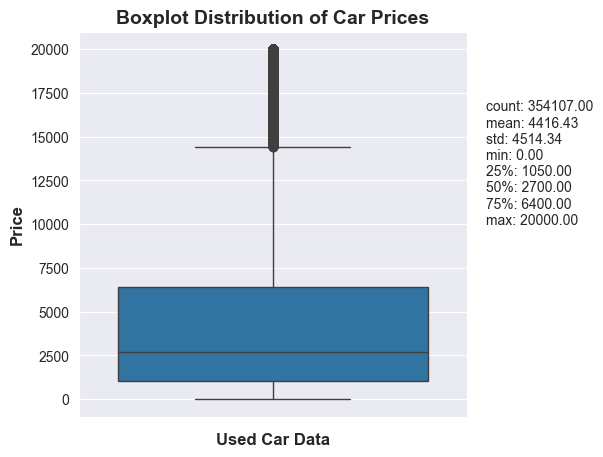

In [29]:
# Box plot of price
boxplot(data, 'price', 'Boxplot Distribution of Car Prices')

I don't consider the prices above 15000 to be outliers as they are continuous, no other concerning values can be observed other than the possible anomalies at lower prices. Anomalies can exist in any price range, so it is challenging to create perfect data without developing a model that can go through the data for me (interesting idea), so we will have to make an assumption. I will try to make the best assumption possible based on what I see in the data. 

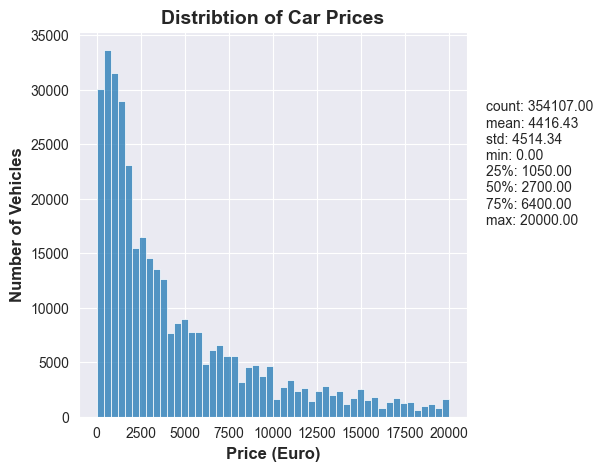

In [30]:
# Create histogram of price
histplot(data = data['price'],
         bins = 50,
         title = 'Distribtion of Car Prices',
         xlabel = 'Price (Euro)')

In [31]:
# Unique prices and percentages at various price levels
price_text_distribution(data, 0, 100)

Number of distinct vehicle prices less than or equal to 0: 1
Percentage of data with price less than 0: 3.04%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 10: 10
Percentage of data with price less than 10: 3.42%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 20: 20
Percentage of data with price less than 20: 3.45%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 30: 27
Percentage of data with price less than 30: 3.48%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 40: 33
Percentage of data with price less than 40: 3.50%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 50: 37
Percentage of data with price less than 50: 3.60%
----------

It's important to recognize that there is a price for each dollar all the way up to almost 30 dollars, more intersting that slightly more than 3% of the data is at price `0`. While 4% of the data is at price `100`. Let's observe the data at price `100` and see if any obvious anomalies occur. 

In [32]:
data[data['price'] == 100].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
964,2016-03-30 22:52:00,100,wagon,1995,manual,116,passat,150000,9,gasoline,volkswagen,yes,2016-03-30,52134,2016-04-02 00:17:00
2139,2016-03-17 13:54:00,100,small,1997,manual,0,twingo,150000,0,gasoline,renault,yes,2016-03-17,12305,2016-03-17 13:54:00
2920,2016-03-05 14:36:00,100,NaN,2018,auto,125,a_klasse,100000,0,gasoline,mercedes_benz,yes,2016-03-05,42719,2016-03-08 17:47:00
3833,2016-03-30 08:36:00,100,sedan,1999,manual,130,primera,150000,4,NaN,nissan,yes,2016-03-30,6712,2016-04-06 22:45:00
4177,2016-03-15 10:37:00,100,NaN,2016,manual,39,swift,150000,1,gasoline,suzuki,yes,2016-03-15,1968,2016-03-15 10:37:00
4216,2016-03-20 10:48:00,100,sedan,2010,manual,0,3er,20000,10,gasoline,bmw,no,2016-03-20,38226,2016-03-28 07:16:00
5426,2016-03-09 12:56:00,100,sedan,1999,manual,67,corsa,150000,4,gasoline,opel,yes,2016-03-09,97769,2016-04-05 22:47:00
5609,2016-03-05 21:55:00,100,small,1998,manual,0,corsa,150000,0,gasoline,opel,yes,2016-03-05,6333,2016-04-03 13:16:00
6029,2016-03-27 21:36:00,100,small,1998,manual,0,NaN,70000,1,gasoline,suzuki,no,2016-03-27,17495,2016-04-05 22:46:00
6197,2016-03-12 12:46:00,100,small,1995,manual,46,corsa,150000,0,gasoline,opel,no,2016-03-12,64409,2016-04-04 08:45:00


What stands out to me in these results is index `2920`, the 2018 Mercedes Benz listed at only 100 dollars. Now, this row does include a null value, so a chance it could be dropped, however, this stands out as a clear anomaly to me. Although we don't know the exact condition of the car, even a non-functional Mercedes Benz would go on the market for more than 100 dollars. For this price to make sense, it would already have had to gone through `vehicle compaction` at the junkyard, which I can safely assume is not the case. Therefore, removing prices less than 100 is safe. Let's investigate to 200 dollars. 

In [33]:
price_text_distribution(data, 100, 200)

Number of distinct vehicle prices less than or equal to 100: 58
Percentage of data with price less than 100: 4.05%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 110: 63
Percentage of data with price less than 110: 4.06%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 120: 69
Percentage of data with price less than 120: 4.14%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 130: 78
Percentage of data with price less than 130: 4.18%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 140: 83
Percentage of data with price less than 140: 4.20%
--------------------------------------------------------------
Number of distinct vehicle prices less than or equal to 150: 87
Percentage of data with price less than 150: 4

115 unique price values at all cars priced below or equal to 200 still concerns me. Let's observe the data at this price point. 

In [34]:
data.query("price == 200").sample(50, random_state=12345)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
336235,2016-03-28 17:43:00,200,small,1992,auto,66,golf,150000,9,gasoline,volkswagen,yes,2016-03-28,50823,2016-03-28 17:43:00
168616,2016-03-10 17:46:00,200,small,2000,manual,104,bravo,150000,0,gasoline,fiat,NaN,2016-03-10,36381,2016-03-21 05:19:00
338589,2016-04-04 16:50:00,200,sedan,1995,manual,75,cordoba,150000,9,gasoline,seat,yes,2016-04-04,32683,2016-04-06 18:46:00
245510,2016-03-24 16:38:00,200,NaN,2016,manual,60,punto,150000,0,NaN,fiat,no,2016-03-24,57072,2016-04-01 12:17:00
171117,2016-04-04 23:51:00,200,small,1997,manual,75,colt,150000,3,gasoline,mitsubishi,no,2016-04-04,58089,2016-04-07 08:15:00
114458,2016-03-16 01:01:00,200,sedan,1998,manual,101,vectra,150000,12,gasoline,opel,yes,2016-03-16,27339,2016-03-20 07:44:00
205978,2016-03-06 17:48:00,200,NaN,2016,NaN,0,corsa,150000,10,NaN,opel,NaN,2016-03-06,67061,2016-03-14 05:45:00
76761,2016-03-31 08:54:00,200,small,1995,manual,60,fiesta,60000,7,gasoline,ford,yes,2016-03-31,2633,2016-04-06 03:15:00
167389,2016-03-23 20:53:00,200,NaN,2000,manual,60,corsa,150000,0,gasoline,opel,NaN,2016-03-23,6886,2016-04-02 04:16:00
97695,2016-03-30 18:36:00,200,small,2000,manual,0,twingo,150000,0,gasoline,renault,yes,2016-03-30,13127,2016-04-07 09:17:00


This data does look much better, however I'm still suspicious of cars priced this low for what i'm seeing in some of the results, but at almost 5.5% of the data at 200 euros, I will leave the cutoff to be 200. 

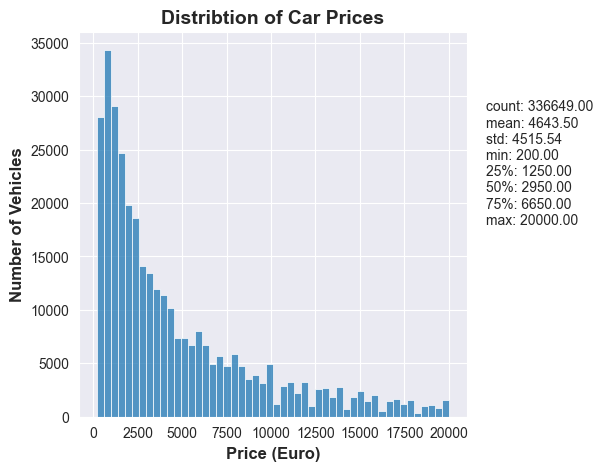

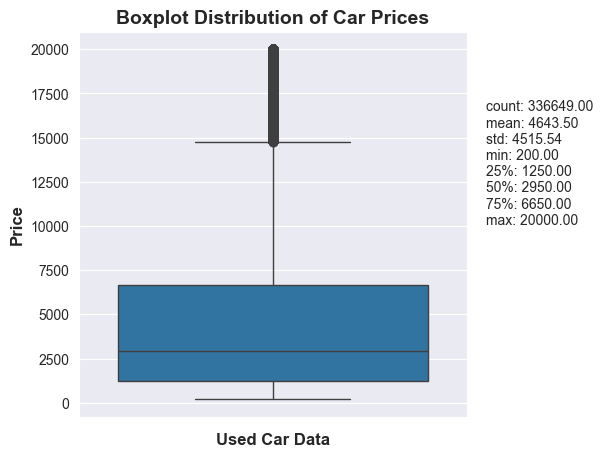

In [35]:
# Remove all prices below 200; check distributions
data = data.query("price >= 200").reset_index(drop = True)

histplot(data = data['price'],
         bins = 50,
         title = 'Distribtion of Car Prices',
         xlabel = 'Price (Euro)')

print()
boxplot(data, 'price', 'Boxplot Distribution of Car Prices')

On review of the data, it's important to recognize that the majority of the used car prices, _at least in this market_, are lower costed than what I would expect today (_possibly data is old_). I'm more confident with leaving the cutoff at 200 euros after seeing this in the data. 

As for the amount of data removed, we still have plenty of data to train machine learning models, no concerns. 

**============================================================================================================**

### Registration Year ###

We saw that the minimum of this field was year `1000`, and the max was `9999`

In [36]:
# Observe the minimums
sort_unique_reg_years = data['registration_year'].sort_values().drop_duplicates()
sort_unique_reg_years[sort_unique_reg_years < 1950]

231488    1000
119323    1001
210613    1039
204875    1111
36951     1234
303452    1300
53477     1400
17315     1500
204069    1600
272986    1602
207294    1800
22566     1910
111541    1923
2157      1925
284921    1927
170277    1928
21505     1929
116757    1930
250411    1931
238605    1932
294173    1933
232211    1934
99636     1935
165594    1936
36071     1937
250031    1938
24908     1940
178938    1941
83695     1942
136840    1943
126459    1944
312798    1945
313833    1946
309948    1947
257640    1948
26153     1949
Name: registration_year, dtype: int64

In [37]:
data.loc[22566] #1910 entry not accurate

date_crawled          2016-03-16 19:58:00
price                                3900
vehicle_type                        wagon
registration_year                    1910
gearbox                            manual
power                                  90
model                              passat
mileage                            150000
registration_month                      0
fuel_type                        gasoline
brand                          volkswagen
not_repaired                          NaN
date_created          2016-03-16 00:00:00
postal_code                         88662
last_seen             2016-04-07 05:45:00
Name: 22566, dtype: object

In [38]:
data.loc[111541] #1923 entry is likely accurate

date_crawled          2016-03-14 14:00:00
price                                8750
vehicle_type                  convertible
registration_year                    1923
gearbox                            manual
power                                  11
model                                  c3
mileage                              5000
registration_month                      0
fuel_type                        gasoline
brand                             citroen
not_repaired                           no
date_created          2016-03-14 00:00:00
postal_code                         27299
last_seen             2016-04-05 16:44:00
Name: 111541, dtype: object

In [39]:
# Remove all entries with registration year less than 1923
data = data.query("registration_year >= 1923").reset_index(drop = True)

In [40]:
data[['date_crawled', 'date_created', 'last_seen']].max()

date_crawled   2016-04-07 14:36:00
date_created   2016-04-07 00:00:00
last_seen      2016-04-07 14:58:00
dtype: datetime64[ns]

The upper limit for any datefield, most importantly `date_created`, is 2016. Therefore, this will be the upper limit of `registration_year`.

In [41]:
# Observe the maximums
sort_unique_reg_years[sort_unique_reg_years > 2016]

327392    2017
112925    2018
70792     2019
25237     2066
17347     2200
115449    2290
132776    2500
243102    2800
44467     2900
215155    3000
15073     3200
75473     3700
80673     3800
90641     4000
19156     4100
264544    4500
83220     4800
118615    5000
39137     5300
189470    5555
47806     5900
51050     5911
112182    6000
90243     7000
292977    7100
280192    7800
304446    8200
63893     8500
16474     8888
43427     9000
123957    9450
206224    9999
Name: registration_year, dtype: int64

Small percentage of data points. Will remove these entries. 

In [42]:
# Remove all entries with registration year greater than 2016
data = data.query("registration_year < 2017").reset_index(drop = True)

In [43]:
# Observe new distribution
data['registration_year'].describe()

count    322967.000000
mean       2002.684432
std           6.778863
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Data looks good. 

**============================================================================================================**

### Power ###

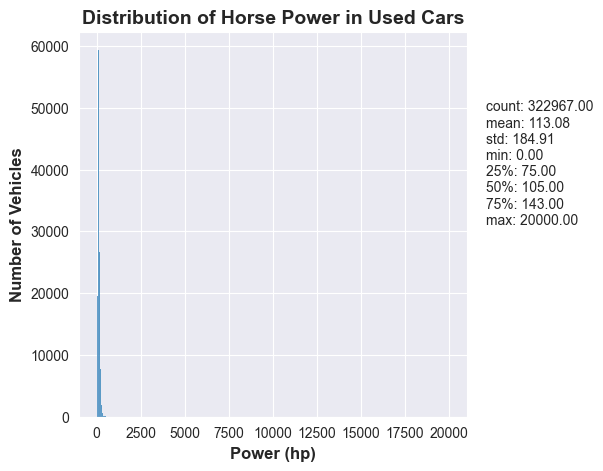

In [44]:
# plot distribution
histplot(data['power'],
         bins = 1000,
         title='Distribution of Horse Power in Used Cars', 
         xlabel='Power (hp)')

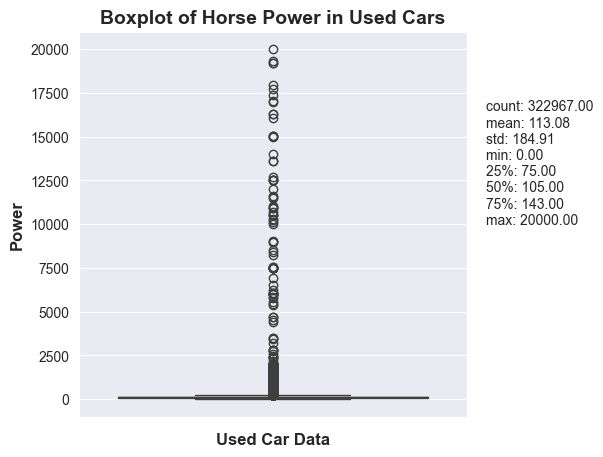

In [45]:
# Plot Boxplot
boxplot(data, 'power', 'Boxplot of Horse Power in Used Cars')

The horsepower values above 2000 are not worth looking into. This is so far beyond the normal limit, with high-performance cars only reaching about 1500. Let's look at the percentage over 500, where most commercial vehicles reside. 

In [46]:
num_outliers_power = data.query("power > 500").shape[0]
num_outliers_power

382

In [47]:
# percentage of outlier power
(num_outliers_power / data.shape[0]) * 100

0.11827833803453604

In [48]:
# Remove these rows
data = data.query("power < 500").reset_index(drop = True)

In [49]:
sorted_power = data['power'].sort_values(ascending = False).drop_duplicates()
sorted_power.head()

106728    490
102850    489
228773    487
316906    476
156107    475
Name: power, dtype: int64

In [50]:
data.shape

(322553, 15)

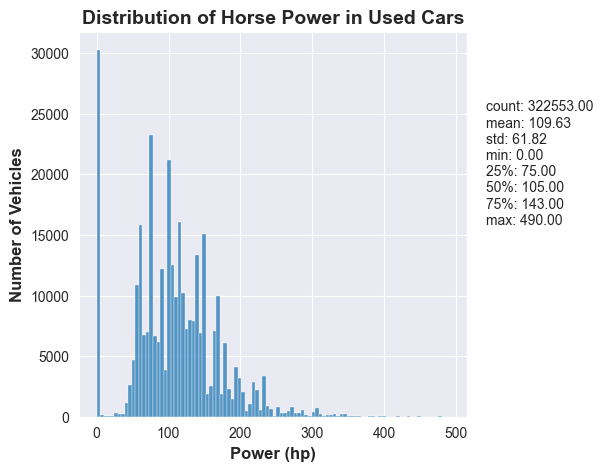

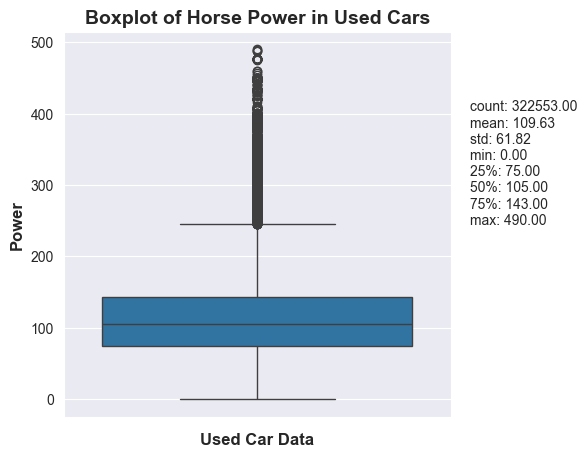

In [51]:
# plot distribution
histplot(data['power'],
         bins = 100,
         title='Distribution of Horse Power in Used Cars', 
         xlabel='Power (hp)')

# Plot Boxplot
boxplot(data, 'power', 'Boxplot of Horse Power in Used Cars')

Large amount of vehicles with a power of `0`. This is likely the same as a nan. **We will perform a modal imputation.** We will perform this after the initial data preprocessing. 

**============================================================================================================**

### Registration Month ###

The `registration_month` column showed 13 different possible categories with values 0-12. This would usually be expected except for the 0th month, but this could represent either errors or missing information. From this point forward, I will treat the 0 values as missing values. Let's take a look at the distribution to decide how to handle this case. 

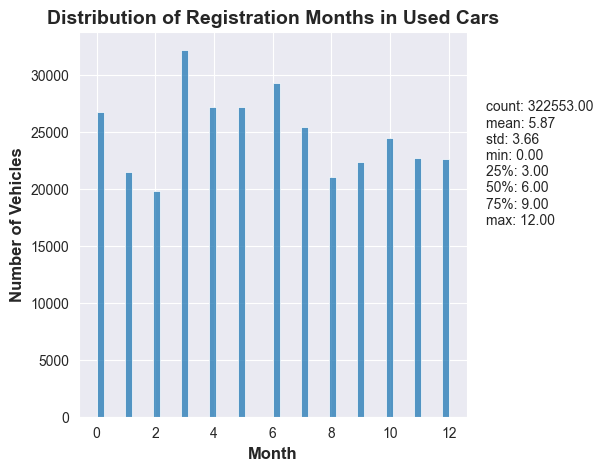

In [52]:
# Plot histogram of registration month
histplot(data['registration_month'],
         bins = 50,
         title='Distribution of Registration Months in Used Cars', 
         xlabel='Month')

In [53]:
# Percentage of 0s
month_0 = data.query("registration_month == 0")
num_of_0 = month_0.shape[0]

perc_of_0 = round((num_of_0 / data.shape[0]) * 100, 2)
print(f"{perc_of_0}% of total data contains missing Registration Month values.")

8.28% of total data contains missing Registration Month values.


The distribution has a mostly uniform shape with the IQs stepping in a unifrom fashion from 0, 3, 6, 9 , and lastly 12. Since there is a large percentage of the data with 0 values in `registration_month`, we will either fill these values or leave as is. First let's take a look at the distributions to check for patterns. 

In [54]:
na_dist_describe(
    data.query("registration_month != 0"),
    month_0,
    'Registration Month'
)

NA Registration Month Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,26704,26704.000000,26704.000000,26704.000000,26704.000000,26704.0,26704,26704.000000,26704
mean,2016-03-21 13:01:01.739065344,2340.272057,2000.253745,70.694802,131806.283703,0.0,2016-03-20 19:08:45.224685568,48012.035987,2016-03-29 15:08:46.091971328
min,2016-03-05 14:07:00,200.000000,1923.000000,0.000000,5000.000000,0.0,2014-03-10 00:00:00,1067.000000,2016-03-05 14:45:00
25%,2016-03-13 19:42:00,599.000000,1997.000000,0.000000,150000.000000,0.0,2016-03-13 00:00:00,27239.000000,2016-03-22 14:47:30
50%,2016-03-21 17:39:30,1200.000000,2000.000000,71.000000,150000.000000,0.0,2016-03-21 00:00:00,46414.000000,2016-04-02 15:45:00
75%,2016-03-29 12:55:00,2800.000000,2004.000000,116.000000,150000.000000,0.0,2016-03-29 00:00:00,66557.000000,2016-04-06 07:45:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,476.000000,150000.000000,0.0,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,2953.306977,8.099595,66.938694,39629.221372,0.0,NaN,25812.053206,NaN



Non NA Registration Month Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,295849,295849.000000,295849.000000,295849.000000,295849.000000,295849.000000,295849,295849.000000,295849
mean,2016-03-21 12:51:06.503587840,4909.513755,2002.904610,113.142458,128029.687442,6.395614,2016-03-20 18:58:31.572457728,51091.310888,2016-03-30 03:24:05.097329920
min,2016-03-05 14:06:00,200.000000,1923.000000,0.000000,5000.000000,1.000000,2015-06-18 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 10:43:00,1400.000000,1999.000000,75.000000,125000.000000,4.000000,2016-03-13 00:00:00,30880.000000,2016-03-23 10:44:00
50%,2016-03-21 17:49:00,3200.000000,2003.000000,109.000000,150000.000000,6.000000,2016-03-21 00:00:00,50169.000000,2016-04-03 23:16:00
75%,2016-03-29 14:48:00,6999.000000,2007.000000,145.000000,150000.000000,9.000000,2016-03-29 00:00:00,71665.000000,2016-04-06 10:45:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,490.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4601.932269,6.601647,60.112805,36916.926687,3.348635,NaN,25710.151665,NaN


It can be observed that vehicles with a registration month of `0` have slightly `higher mileage`, `lower power`, and `lower prices` compared to those with valid registration months. However, given the significant amount of missing data in `power` (_the 0 values analyzed earlier_), which will be addressed through imputation, I do not believe that the missing `registration_month` values are related to `power`.

While there is some evidence suggesting that `registration_month = 0` is not entirely random (_due to differences in price_), it is not strongly related to key features such as `power` or `mileage`. Therefore, rather than treat these values as missing-at-random or attempting imputation, we will leave the `0 values` intact. This decision avoids unnecessary complexity and reduces the risk of `overfitting on price` alone. Additionally, I'm not expecting `registration_month` to be a significant feature in the ML algorithms compared to other features; operating on this assumption, this will allow the models to handle the `0 values` appropriately. This will also strengthen our imputation techniques used elsewhere. 

[Back to Contents](#contents)

**<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>**

## 3.4 Missing Values ##
<a id='missing'></a>

Next we will investage the missing values within the following columns: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `not_repaired`

### Vehicle Type ###

In [55]:
# extract categorical columns
cat_cols = [col for col in data.columns if data[col].dtype == 'object']

In [56]:
# observe the categories
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

<a id='cell_ref_1'></a>

In [57]:
prev_veh_typ_dist = data['vehicle_type'].value_counts(normalize = True)
prev_veh_typ_dist

vehicle_type
sedan          0.289962
small          0.247513
wagon          0.206642
bus            0.092380
convertible    0.064734
coupe          0.050505
suv            0.038477
other          0.009788
Name: proportion, dtype: float64

In [58]:
# percentge
calc_na('vehicle_type')

The number of missing values in vehicle_type: 17,692
The percentage of missing values in vehicle_type: 5.48%


In [59]:
veh_t_na = data.query("vehicle_type.isna()")

na_dist_describe(
    data.query("vehicle_type != 'np.nan'"),
    veh_t_na,
    'Vehicle Type'
)

NA Vehicle Type Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,17692,17692.00000,17692.00000,17692.000000,17692.000000,17692.000000,17692,17692.000000,17692
mean,2016-03-21 08:22:14.114854144,2424.28007,2007.38475,61.829584,129849.366946,3.701673,2016-03-20 13:44:50.029391872,48132.095749,2016-03-29 00:56:46.166628864
min,2016-03-05 14:06:00,200.00000,1960.00000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:45:00
25%,2016-03-13 08:48:45,550.00000,2000.00000,0.000000,125000.000000,0.000000,2016-03-13 00:00:00,27478.000000,2016-03-21 17:48:45
50%,2016-03-21 13:48:00,1150.00000,2009.00000,60.000000,150000.000000,3.000000,2016-03-21 00:00:00,46240.000000,2016-04-01 09:44:00
75%,2016-03-29 04:36:00,2950.00000,2016.00000,105.000000,150000.000000,7.000000,2016-03-29 00:00:00,66572.750000,2016-04-06 05:17:00
max,2016-04-07 14:07:00,20000.00000,2016.00000,476.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,3140.51729,9.92949,63.634829,40915.366809,4.040672,NaN,25591.562995,NaN



Non NA Vehicle Type Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,322553,322553.000000,322553.000000,322553.000000,322553.000000,322553.000000,322553,322553.000000,322553
mean,2016-03-21 12:51:55.782832384,4696.807532,2002.685146,109.628238,128342.349939,5.866124,2016-03-20 18:59:22.376415744,50836.379274,2016-03-30 02:23:12.507153920
min,2016-03-05 14:06:00,200.000000,1923.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:38:00,1270.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,30539.000000,2016-03-23 08:46:00
50%,2016-03-21 17:49:00,2999.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,49681.000000,2016-04-03 20:44:00
75%,2016-03-29 14:46:00,6799.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,71364.000000,2016-04-06 10:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,490.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4543.984565,6.777781,61.823580,37163.505025,3.659380,NaN,25732.557427,NaN


In [60]:
# call the function
na_cat_dist(data.query("vehicle_type != 'np.nan'"), veh_t_na, cat_cols, 'vehicle_type')

,gearbox,non_na_data,na_data
0,manual,0.797683,0.85943
1,auto,0.202317,0.14057


,model,non_na_data,na_data
0,golf,0.085155,0.133558
1,other,0.073637,0.068122
2,3er,0.060012,0.043257
3,polo,0.037374,0.050627
4,corsa,0.035513,0.047734


,fuel_type,non_na_data,na_data
0,gasoline,0.980168,0.98013
1,other,0.019832,0.01987


,brand,non_na_data,na_data
0,volkswagen,0.215010,0.262322
1,opel,0.109787,0.132263
2,bmw,0.106497,0.073027
3,mercedes_benz,0.093256,0.067997
4,audi,0.084851,NaN
5,ford,NaN,0.074780


,not_repaired,non_na_data,na_data
0,no,0.883968,0.730847
1,yes,0.116032,0.269153


There are some observable patterns in the missing data. A higher percentage of the missing data is present in `manual gearbox`, certain `model` types, and slightly more repaired vehicles. However, vehicle type is an important feature in this dataset, and I believe it can be inferred via imputation to fill in that missing data, since the data does not appear to be missing completely at random.  

We will perform a modal imputation based on `brand` and `registration_year`.

In [61]:
data['vehicle_type'] = data.groupby(
    ['brand', 'registration_year']
)['vehicle_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'other'))

In [62]:
calc_na('vehicle_type')

The number of missing values in vehicle_type: 0
The percentage of missing values in vehicle_type: 0.00%


In [63]:
# Compare the distribution with cell
prev_veh_typ_dist

vehicle_type
sedan          0.289962
small          0.247513
wagon          0.206642
bus            0.092380
convertible    0.064734
coupe          0.050505
suv            0.038477
other          0.009788
Name: proportion, dtype: float64

In [64]:
data['vehicle_type'].value_counts(normalize = True)

vehicle_type
sedan          0.285277
small          0.267401
wagon          0.197530
bus            0.088305
convertible    0.061956
coupe          0.050705
suv            0.036924
other          0.011902
Name: proportion, dtype: float64

The fill looks like it worked wonderfully!

### Model ###

In [65]:
# Observe the cats
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       'rio', 'touareg',

In [66]:
prev_model_dist = data['model'].value_counts(normalize = True)
prev_model_dist.head(15)

model
golf        0.085155
other       0.073637
3er         0.060012
polo        0.037374
corsa       0.035513
astra       0.031742
passat      0.030778
a4          0.030459
c_klasse    0.025828
5er         0.024236
e_klasse    0.020875
a3          0.018396
focus       0.017753
a6          0.016984
fiesta      0.016711
Name: proportion, dtype: float64

In [67]:
calc_na('model')

The number of missing values in model: 14,666
The percentage of missing values in model: 4.55%


In [68]:
model_na = data.query("model.isna()")

na_dist_describe(
    data.query("model != 'np.nan'"),
    model_na,
    'model'
)

NA model Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,14666,14666.000000,14666.000000,14666.000000,14666.000000,14666.000000,14666,14666.000000,14666
mean,2016-03-21 11:25:57.173053440,3496.544797,1999.895950,88.388654,125185.462976,4.538047,2016-03-20 17:37:27.974907904,48190.662962,2016-03-29 16:56:12.923769344
min,2016-03-05 14:06:00,200.000000,1925.000000,0.000000,5000.000000,0.000000,2015-11-23 00:00:00,1067.000000,2016-03-05 14:49:00
25%,2016-03-13 11:36:15,800.000000,1997.000000,0.000000,125000.000000,0.000000,2016-03-13 00:00:00,27283.000000,2016-03-22 18:15:00
50%,2016-03-21 17:39:00,1800.000000,2000.000000,85.000000,150000.000000,4.000000,2016-03-21 00:00:00,46342.000000,2016-04-02 20:40:30
75%,2016-03-29 11:55:45,4500.000000,2005.000000,136.000000,150000.000000,8.000000,2016-03-29 00:00:00,66699.000000,2016-04-06 08:45:00
max,2016-04-07 13:36:00,20000.000000,2016.000000,450.000000,150000.000000,12.000000,2016-04-07 00:00:00,99986.000000,2016-04-07 14:58:00
std,NaN,4098.125762,10.135634,75.365339,44111.020972,3.982020,NaN,26050.530801,NaN



Non NA model Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,322553,322553.000000,322553.000000,322553.000000,322553.000000,322553.000000,322553,322553.000000,322553
mean,2016-03-21 12:51:55.782832384,4696.807532,2002.685146,109.628238,128342.349939,5.866124,2016-03-20 18:59:22.376415744,50836.379274,2016-03-30 02:23:12.507153920
min,2016-03-05 14:06:00,200.000000,1923.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:38:00,1270.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,30539.000000,2016-03-23 08:46:00
50%,2016-03-21 17:49:00,2999.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,49681.000000,2016-04-03 20:44:00
75%,2016-03-29 14:46:00,6799.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,71364.000000,2016-04-06 10:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,490.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4543.984565,6.777781,61.823580,37163.505025,3.659380,NaN,25732.557427,NaN


In [69]:
na_cat_dist(data.query("model != 'np.nan'"), model_na, cat_cols, 'model')

,vehicle_type,non_na_data,na_data
0,sedan,0.285277,0.263057
1,small,0.267401,0.305264
2,wagon,0.197530,0.138415
3,bus,0.088305,0.065867
4,convertible,0.061956,NaN
5,coupe,NaN,0.071253


,gearbox,non_na_data,na_data
0,manual,0.797683,0.781501
1,auto,0.202317,0.218499


,fuel_type,non_na_data,na_data
0,gasoline,0.980168,0.960737
1,other,0.019832,0.039263


,brand,non_na_data,na_data
0,volkswagen,0.215010,0.176463
1,opel,0.109787,0.094777
2,bmw,0.106497,0.096209
3,mercedes_benz,0.093256,0.062730
4,audi,0.084851,NaN
5,sonstige_autos,NaN,0.172031


,not_repaired,non_na_data,na_data
0,no,0.883968,0.795758
1,yes,0.116032,0.204242


Given that the missing data seems non-random and not easily explained by the other variables, I will be filling the missing values with a new 'unknown' value. This will allow the model to learn about this group as a unique class rather than trying to force-fit them into existing categories. There are also a large amount of existing model types, and a modal or ML imputation could lead to too much bias or overfitting.  Also, the differences in the distribution follow the same patterns of the previous categorical features, but not as severe so creating a new option appears as the better option.

In [70]:
# convert to unknown
data['model'] = data['model'].fillna('unkown')

#confirm
calc_na('model')

The number of missing values in model: 0
The percentage of missing values in model: 0.00%


The data is filled. Let's move to the next feature. 

### Fuel Type ###

In [71]:
# observe column
data['fuel_type'].unique()

array(['gasoline', nan, 'other'], dtype=object)

In [72]:
prev_fuel_dist = data['fuel_type'].value_counts(normalize = True)
prev_fuel_dist

fuel_type
gasoline    0.980168
other       0.019832
Name: proportion, dtype: float64

In [73]:
data['fuel_type'].value_counts()

fuel_type
gasoline    294663
other         5962
Name: count, dtype: int64

In [74]:
calc_na('fuel_type')

The number of missing values in fuel_type: 21,928
The percentage of missing values in fuel_type: 6.80%


In [75]:
model_na = data.query("fuel_type.isna()")

na_dist_describe(
    data.query("fuel_type != 'np.nan'"),
    model_na,
    'fule_type'
)

NA fule_type Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,21928,21928.000000,21928.000000,21928.000000,21928.000000,21928.000000,21928,21928.000000,21928
mean,2016-03-21 08:56:24.021342464,2714.540907,2001.706403,74.940715,129850.191536,3.885945,2016-03-20 15:40:31.083546368,48484.461100,2016-03-29 04:14:25.682232832
min,2016-03-05 14:07:00,200.000000,1925.000000,0.000000,5000.000000,0.000000,2016-01-13 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 00:36:00,650.000000,1997.000000,0.000000,125000.000000,0.000000,2016-03-12 00:00:00,27478.000000,2016-03-21 22:17:15
50%,2016-03-21 14:49:00,1393.500000,2000.000000,75.000000,150000.000000,3.000000,2016-03-21 00:00:00,47137.000000,2016-04-01 18:45:00
75%,2016-03-29 08:00:00,3300.000000,2006.000000,118.000000,150000.000000,7.000000,2016-03-29 00:00:00,66806.000000,2016-04-06 06:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,476.000000,150000.000000,12.000000,2016-04-07 00:00:00,99986.000000,2016-04-07 14:58:00
std,NaN,3377.252693,9.159875,66.978063,40532.936080,4.053029,NaN,25793.052697,NaN



Non NA fule_type Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,322553,322553.000000,322553.000000,322553.000000,322553.000000,322553.000000,322553,322553.000000,322553
mean,2016-03-21 12:51:55.782832384,4696.807532,2002.685146,109.628238,128342.349939,5.866124,2016-03-20 18:59:22.376415744,50836.379274,2016-03-30 02:23:12.507153920
min,2016-03-05 14:06:00,200.000000,1923.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:38:00,1270.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,30539.000000,2016-03-23 08:46:00
50%,2016-03-21 17:49:00,2999.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,49681.000000,2016-04-03 20:44:00
75%,2016-03-29 14:46:00,6799.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,71364.000000,2016-04-06 10:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,490.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4543.984565,6.777781,61.823580,37163.505025,3.659380,NaN,25732.557427,NaN


In [76]:
# perform modal imputation
data['fuel_type'] = data.groupby(
    ['vehicle_type', 'model']
)['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))

In [77]:
calc_na('fuel_type')

The number of missing values in fuel_type: 0
The percentage of missing values in fuel_type: 0.00%


In [78]:
prev_fuel_dist

fuel_type
gasoline    0.980168
other       0.019832
Name: proportion, dtype: float64

In [79]:
data['fuel_type'].value_counts(normalize = True)

fuel_type
gasoline    0.98133
other       0.01853
unknown     0.00014
Name: proportion, dtype: float64

In [80]:
data['fuel_type'].value_counts()

fuel_type
gasoline    316531
other         5977
unknown         45
Name: count, dtype: int64

After careful consideration of the distribution of fuel types after imputation and the overall imbalance in the adta, I will decide to combine the 47 "unknown" entrries into the "other" category. By combining these entries, we maintain the integrity of the dataset while simplifying the `fuel_type` variable for the model. This decision reduces noise and ensures that the model can focus on more meaningful distinctions between `gasoline` and essentially non-gasoline vehicles. This improves model performance and interpretability. 

In [81]:
# combine the unknowns
data['fuel_type'] = data['fuel_type'].replace({
    'unknown': 'other'
})

In [82]:
data['fuel_type'].value_counts()

fuel_type
gasoline    316531
other         6022
Name: count, dtype: int64

### Not Repaired ###

In [83]:
calc_na('not_repaired')

The number of missing values in not_repaired: 56,384
The percentage of missing values in not_repaired: 17.48%


In [84]:
prev_repaired_dist = data['not_repaired'].value_counts(normalize = True)
prev_repaired_dist

not_repaired
no     0.883968
yes    0.116032
Name: proportion, dtype: float64

In [85]:
repaired_na = data.query("not_repaired.isna()")

na_dist_describe(
    data.query("not_repaired != 'np.nan'"),
    repaired_na,
    'not_repaired'
)

NA not_repaired Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,56384,56384.000000,56384.000000,56384.000000,56384.000000,56384.000000,56384,56384.000000,56384
mean,2016-03-21 11:47:59.335981824,2983.771017,2001.166306,82.803490,132848.148411,4.742196,2016-03-20 18:00:44.438138624,48602.840327,2016-03-29 04:05:02.545402880
min,2016-03-05 14:06:00,200.000000,1927.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:47:00
25%,2016-03-13 13:48:30,750.000000,1998.000000,0.000000,150000.000000,0.000000,2016-03-13 00:00:00,28259.000000,2016-03-21 20:17:00
50%,2016-03-21 16:49:00,1650.000000,2001.000000,80.000000,150000.000000,4.000000,2016-03-21 00:00:00,47169.000000,2016-04-01 19:45:00
75%,2016-03-29 12:59:15,3750.000000,2005.000000,125.000000,150000.000000,8.000000,2016-03-29 00:00:00,66538.000000,2016-04-06 06:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,476.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,3455.673757,7.652507,66.383441,36641.917960,4.043650,NaN,25193.377533,NaN



Non NA not_repaired Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,322553,322553.000000,322553.000000,322553.000000,322553.000000,322553.000000,322553,322553.000000,322553
mean,2016-03-21 12:51:55.782832384,4696.807532,2002.685146,109.628238,128342.349939,5.866124,2016-03-20 18:59:22.376415744,50836.379274,2016-03-30 02:23:12.507153920
min,2016-03-05 14:06:00,200.000000,1923.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:38:00,1270.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,30539.000000,2016-03-23 08:46:00
50%,2016-03-21 17:49:00,2999.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,49681.000000,2016-04-03 20:44:00
75%,2016-03-29 14:46:00,6799.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,71364.000000,2016-04-06 10:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,490.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4543.984565,6.777781,61.823580,37163.505025,3.659380,NaN,25732.557427,NaN


In [86]:
na_cat_dist(data.query("not_repaired != 'np.nan'"), repaired_na, cat_cols, 'not_repaired')

,vehicle_type,non_na_data,na_data
0,sedan,0.285277,0.268551
1,small,0.267401,0.343448
2,wagon,0.197530,0.175245
3,bus,0.088305,0.062979
4,convertible,0.061956,NaN
5,coupe,NaN,0.052373


,gearbox,non_na_data,na_data
0,manual,0.797683,0.824098
1,auto,0.202317,0.175902


,model,non_na_data,na_data
0,golf,0.081283,0.086035
1,other,0.070289,0.061436
2,3er,0.057284,0.054022
3,unkown,0.045468,0.107105
4,polo,0.035675,0.041377


,fuel_type,non_na_data,na_data
0,gasoline,0.98133,0.982211
1,other,0.01867,0.017789


,brand,non_na_data,na_data
0,volkswagen,0.215010,0.236503
1,opel,0.109787,0.123759
2,bmw,0.106497,0.095541
3,mercedes_benz,0.093256,0.082789
4,audi,0.084851,0.079597


The issue with the data contained in this column is that _numerically_, it appears to relate to price, mileage and power. Indicating the missing data is for older, slower cars, that likely have not been repaired, but no way to know for sure. The unique issue with this column however, is it is related to itself, and not to many other features, especially categorical features as the distributions are nearly identical. 

Given this, there are two options: we can mark all missing values as unknown, or fill the values based on the current probabilities in the distribution which would lead to further assumptions, which so far we've kept optimized. Therefore, I will choose to introduce the missing values as unknown to perserve the uncertainty and reduce assumptions and bias.  

In [87]:
# fill the missing with unknown
data['not_repaired'] = data['not_repaired'].fillna('unkown')

# confirm
data['not_repaired'].value_counts()

not_repaired
no        235285
unkown     56384
yes        30884
Name: count, dtype: int64

### Gearbox ###

In [88]:
# observe the categories
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [89]:
prev_gearbox_dist = data['gearbox'].value_counts(normalize = True)
prev_gearbox_dist

gearbox
manual    0.797683
auto      0.202317
Name: proportion, dtype: float64

In [90]:
calc_na('gearbox')

The number of missing values in gearbox: 13,829
The percentage of missing values in gearbox: 4.29%


In [91]:
gearbox_na = data.query("gearbox.isna()")

na_dist_describe(
    data.query("gearbox != 'np.nan'"),
    gearbox_na,
    'Gearbox'
)

NA Gearbox Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,13829,13829.000000,13829.000000,13829.000000,13829.000000,13829.000000,13829,13829.000000,13829
mean,2016-03-21 05:54:21.298720256,2836.214694,2001.243618,36.900788,124930.580664,3.963121,2016-03-20 11:13:30.383975680,48715.193434,2016-03-28 11:49:50.515583232
min,2016-03-05 14:06:00,200.000000,1925.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:18:00
25%,2016-03-12 22:53:00,700.000000,1998.000000,0.000000,125000.000000,0.000000,2016-03-12 00:00:00,28790.000000,2016-03-20 12:25:00
50%,2016-03-21 02:37:00,1700.000000,2002.000000,0.000000,150000.000000,3.000000,2016-03-21 00:00:00,47608.000000,2016-03-31 22:17:00
75%,2016-03-29 01:57:00,3500.000000,2006.000000,71.000000,150000.000000,7.000000,2016-03-29 00:00:00,66538.000000,2016-04-06 05:17:00
max,2016-04-07 14:07:00,20000.000000,2016.000000,487.000000,150000.000000,12.000000,2016-04-07 00:00:00,99986.000000,2016-04-07 14:58:00
std,NaN,3266.055113,9.479048,57.112393,44608.454193,4.186870,NaN,25140.649724,NaN



Non NA Gearbox Data:



,date_crawled,price,registration_year,power,mileage,registration_month,date_created,postal_code,last_seen
count,322553,322553.000000,322553.000000,322553.000000,322553.000000,322553.000000,322553,322553.000000,322553
mean,2016-03-21 12:51:55.782832384,4696.807532,2002.685146,109.628238,128342.349939,5.866124,2016-03-20 18:59:22.376415744,50836.379274,2016-03-30 02:23:12.507153920
min,2016-03-05 14:06:00,200.000000,1923.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:38:00,1270.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,30539.000000,2016-03-23 08:46:00
50%,2016-03-21 17:49:00,2999.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,49681.000000,2016-04-03 20:44:00
75%,2016-03-29 14:46:00,6799.000000,2007.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,71364.000000,2016-04-06 10:17:00
max,2016-04-07 14:36:00,20000.000000,2016.000000,490.000000,150000.000000,12.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4543.984565,6.777781,61.823580,37163.505025,3.659380,NaN,25732.557427,NaN


Due to the differences in `price` and `power`, it is possible that the missing values in `gearbox` do not occur completely at random. Previously I was not concerned with `power` as we plan to impute the zeros that are bringing down the mean for the NA distribution. However the significant presence in combination with the lower value of the vehicles informs us that these missing values may not have occurred randomly. Let's take a look at the distributions of the categorical variables. 

In [92]:
# call the function
na_cat_dist(data.query("gearbox != 'np.nan'"), gearbox_na, cat_cols, 'gearbox')

,vehicle_type,non_na_data,na_data
0,sedan,0.285277,0.262853
1,small,0.267401,0.403572
2,wagon,0.197530,0.130378
3,bus,0.088305,0.059585
4,convertible,0.061956,0.053872


,model,non_na_data,na_data
0,golf,0.081283,0.075566
1,other,0.070289,0.073903
2,3er,0.057284,0.035360
3,unkown,0.045468,0.160677
4,polo,0.035675,NaN
5,fortwo,NaN,0.053583


,fuel_type,non_na_data,na_data
0,gasoline,0.98133,0.987345
1,other,0.01867,0.012655


,brand,non_na_data,na_data
0,volkswagen,0.215010,0.240220
1,opel,0.109787,0.109408
2,bmw,0.106497,0.071227
3,mercedes_benz,0.093256,0.070215
4,audi,0.084851,0.071083


,not_repaired,non_na_data,na_data
0,no,0.729446,0.349772
1,unkown,0.174805,0.573505
2,yes,0.095749,0.076723


In addition to `power` and `price`, it looks like certain vehicle types in `vehicle_type` are more likely to have missing values in `gearbox`. I believe presented with this information, mode imputation should be executed like `vehicle_type` above. We will not group by `power` as doing so would result in a very small amount of 'other' results, which tells me that the relationship between `power` and `gearbox` isn't as strong in the dataset. Including `power` could force the imputation into categories that don't necessarily fit the patterns. 

In [93]:
# perform imputation on most related features
data['gearbox'] = data.groupby(
    ['model']
)['gearbox'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown')
)

In [94]:
calc_na('gearbox')

The number of missing values in gearbox: 0
The percentage of missing values in gearbox: 0.00%


In [95]:
data['gearbox'].value_counts(normalize = True)

gearbox
manual    0.801933
auto      0.198067
Name: proportion, dtype: float64

In [96]:
prev_gearbox_dist

gearbox
manual    0.797683
auto      0.202317
Name: proportion, dtype: float64

The filled data looks good. Let's check all missing values.

In [97]:
# confirm all missing values addressed
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
postal_code           0
last_seen             0
dtype: int64

## 3.5 Dimensionality Reduction ##
<a id='dimension'></a>

In the previous modules of this section, we determined a few issues to address:
- Remove `postal_code`
- Combine `registration_year` and `date_created` to form age of vehicle
- Investigate the 0-powered vehicles

### 0-Powered Vehicles ###
Let's observe the distributions between the vehicles with 0 power, and vehicles that have valid powers. 

In [98]:
power_0 = data.query("power == 0")
non_power_0 = data.query("power != 0")

power_0.sample(5, random_state = 123456)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
142422,2016-04-01 04:36:00,200,sedan,1990,manual,0,corsa,5000,0,gasoline,opel,unkown,2016-04-01,39343,2016-04-05 03:17:00
173600,2016-03-29 13:37:00,800,small,2016,manual,0,polo,150000,9,gasoline,volkswagen,unkown,2016-03-29,87600,2016-03-31 07:15:00
203501,2016-03-21 20:44:00,2199,wagon,2000,manual,0,passat,150000,10,gasoline,volkswagen,unkown,2016-03-21,47053,2016-03-24 10:17:00
34641,2016-03-25 21:52:00,10499,bus,2008,auto,0,touran,150000,4,gasoline,volkswagen,no,2016-03-25,78467,2016-04-07 05:45:00
21418,2016-03-06 11:38:00,555,small,1997,manual,0,corsa,150000,1,gasoline,opel,yes,2016-03-06,75417,2016-03-07 21:48:00


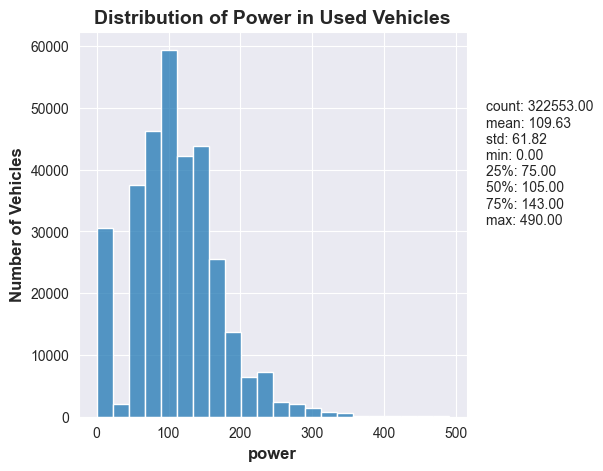

In [99]:
histplot(data = data['power'], 
         bins = 22, 
         title = 'Distribution of Power in Used Vehicles', 
         xlabel = 'power')

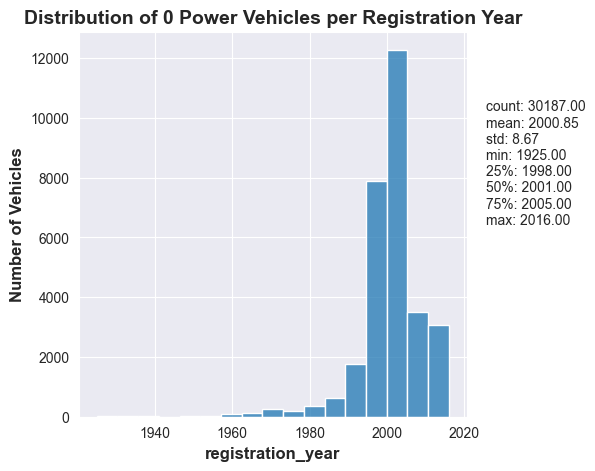

In [100]:
histplot(data = power_0['registration_year'], 
         bins = 17, 
         title = 'Distribution of 0 Power Vehicles per Registration Year', 
         xlabel = 'registration_year')

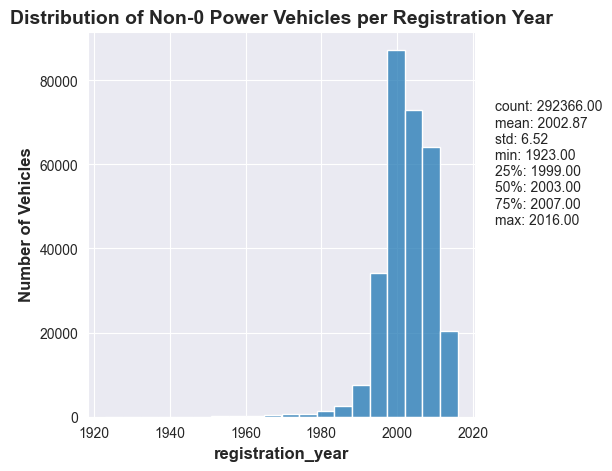

In [101]:
histplot(data = non_power_0['registration_year'],
         bins = 20,
         title = 'Distribution of Non-0 Power Vehicles per Registration Year',
         xlabel = 'registration_year')

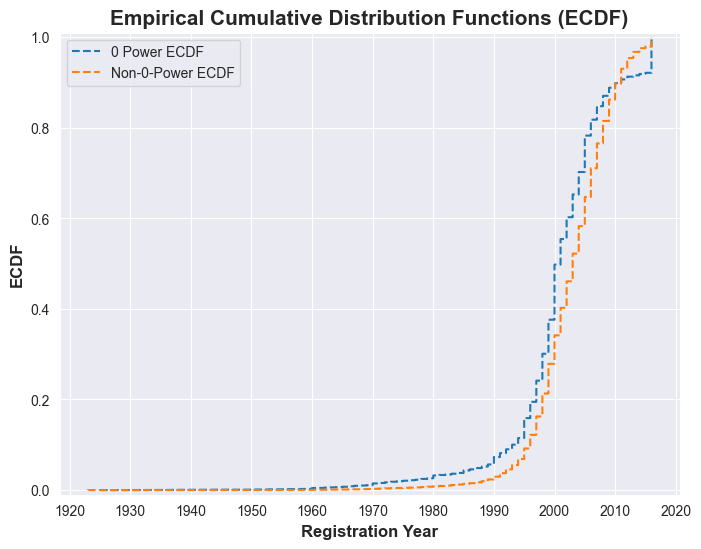

In [102]:
# Plot ECDFs
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))

sns.ecdfplot(data = power_0['registration_year'],
             label = '0 Power ECDF',
             linestyle = '--')

sns.ecdfplot(data = non_power_0['registration_year'],
             label = 'Non-0-Power ECDF',
             linestyle = '--')

plt.title("Empirical Cumulative Distribution Functions (ECDF)",
          fontsize = 15, fontweight = 'bold')
plt.xlabel("Registration Year", fontsize = 12, fontweight = 'bold')
tick_pos = range(1920, 2021, 10)
plt.xticks(tick_pos)
plt.ylabel('ECDF', fontsize = 12, fontweight = 'bold')
plt.ylim(-0.01, 1.01)
plt.legend()
plt.grid(True)
plt.show()

The clear divergence between the distributions of vehicles with `0 power` and `non-0 power` especially pre-2010, indicates that the `0 power` group likely contains missing or incorrect values as we suspected, especially among the older vehicles. We can see specifically the gap converge breifly pre-2000, and then converge again around 2009 with the `non-0 power` vehicles appearing in greater numbers post this year. 

Imputing the missing power values based on the distribution of `non-0 power` vehicles is the logical approach, and the one I will be choosing, to address this inconsistency and bring the dataset into alignment with the expected vehicle characteristics overtime. Grouping by registration year and performing a modal imputation should suffice, versus the KNN imputation hypothesized earlier. 

In [103]:
data['power'].value_counts().head()

power
0      30187
75     21615
60     14145
150    13650
101    12323
Name: count, dtype: int64

In [104]:
# perform modal imputation; avoid cases where mode is 0
data['power'] = data.groupby('registration_year')['power'].transform(
    lambda x: x.replace(0, x[x != 0].mode()[0] if not x[x != 0].mode().empty else 0)
)

In [105]:
data['power'].value_counts().head()

power
75     42245
140    17920
60     14400
150    13650
90     13564
Name: count, dtype: int64

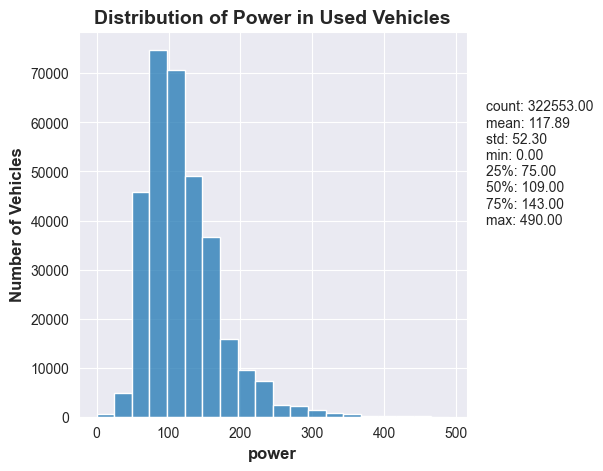

In [106]:
histplot(data = data['power'], 
         bins = 20, 
         title = 'Distribution of Power in Used Vehicles', 
         xlabel = 'power')

Distribution looks great! 0 values have been handled.

### Irrelevant Features ###

There is no reason to keep `postal_code` in our dataset as it would only confuse the learning algorithms of our models by adding noise, reducing its ability to generalize price well. Generally, this would increase the error rate and therefore, I will be removing this feature. 

In [107]:
# remove postal code
data = data.drop(columns = ['postal_code', 'date_crawled', 'last_seen'])

In [108]:
# Observe
data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created
0,480,sedan,1993,manual,90,golf,150000,0,gasoline,volkswagen,unkown,2016-03-24
1,18300,coupe,2011,manual,190,unkown,125000,5,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unkown,2016-03-14


For similar reasons, `date_crawled` and `last_seen` are also irrelevant features for our models. So those have been removed as well in the code found above. 

### Create Vehicle Age (_Feature Engineering_) ###

In [109]:
data['age'] = data['date_created'].dt.year - data['registration_year']
data.head(1)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,age
0,480,sedan,1993,manual,90,golf,150000,0,gasoline,volkswagen,unkown,2016-03-24,23


In [110]:
data = data.drop(columns = ['registration_year', 'date_created'])

In [111]:
calc_na('age')

The number of missing values in age: 0
The percentage of missing values in age: 0.00%


In [112]:
data.head(3)

,price,vehicle_type,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,age
0,480,sedan,manual,90,golf,150000,0,gasoline,volkswagen,unkown,23
1,18300,coupe,manual,190,unkown,125000,5,gasoline,audi,yes,5
2,9800,suv,auto,163,grand,125000,8,gasoline,jeep,unkown,12


In [113]:
# confirm no negatives
np.sort(data['age'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 91, 93], dtype=int64)

[Back to Contents](#contents)

# 4. Exploratory Data Analysis #
<a id='eda'></a>
_________________________________________________________________________________________________________________________________________________________

The functions below will help automate tasks in this section. 

In [114]:
def graph_numerical_features(data: DataFrame):
    '''
        This function serves to graph five numerical features from the provided data related to this project: 
        price (target), power, mileage, registration_month, age. 

        Inputs:
        data - dataframe: the data used to plot the numerical features.
    '''
    sns.set_style('darkgrid')
    
    # (column, x-label)
    numerical_features = [
        ('price', 'Price'),
        ('power', 'Power'),
        ('mileage', 'Mileage'),
        ('registration_month', 'Registration Month'),
        ('age', 'Age')
    ]

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))
    fig.suptitle("Distribution of All Numerical Features", fontsize = 17, fontweight = 'bold')
    axs = axs.flatten()

    for i, (feature, xlabel) in enumerate(numerical_features):
        sns.histplot(x = data[feature], bins = 65, ax=axs[i], color='blue')
        axs[i].set_title(xlabel, fontsize = 15, fontweight = 'bold')
        axs[i].set_xlabel(xlabel, fontweight = 'bold')
        axs[i].set_ylabel('Number of Customers', fontweight = 'bold')

    # Hide 6th subplot
    axs[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [115]:
def graph_categorical_features(data: DataFrame):
    '''
    This function serves to graph categorical features from the provided data related to this project:
        vehicle_type, gearbox, model, fuel_type, brand, and not_repaired

    Inputs:
    data - DataFrame: thbe data used to plot the numerical features
    '''

    # set up figure
    sns.set_style('whitegrid')
    
    fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10))
    fig.suptitle("Distribution of All Categorical Features with Mean Prices",
                 fontsize = 17, fontweight = 'bold')
    axs = axs.flatten()
    
    # initialize any varibales
    grouped_data = {}
    
    # fill dictionary
    for col in cat_cols:
        group_by_col = data.groupby(col)['price'].mean().sort_values(ascending = False)[:10]
        grouped_data[col] = group_by_col
    
    # chart the data
    for i, col in enumerate(cat_cols):
        palette =  sns.color_palette('mako_r', n_colors = len(grouped_data[col]))
        
        sns.barplot(
            y = grouped_data[col].index,
            x = grouped_data[col].values,
            hue = grouped_data[col].index,
            palette = palette,
            ax = axs[i])
    
        axs[i].set_title(f"{col.replace('_', ' ').title()}", fontsize = 13, fontweight = 'bold')
        axs[i].set_ylabel('')
        axs[i].set_xlabel("Price (euro)", fontsize = 10, fontweight = 'bold')
    
    plt.tight_layout()
    plt.show()

## 4.1 Numerical Features ##
<a id='nums'></a>

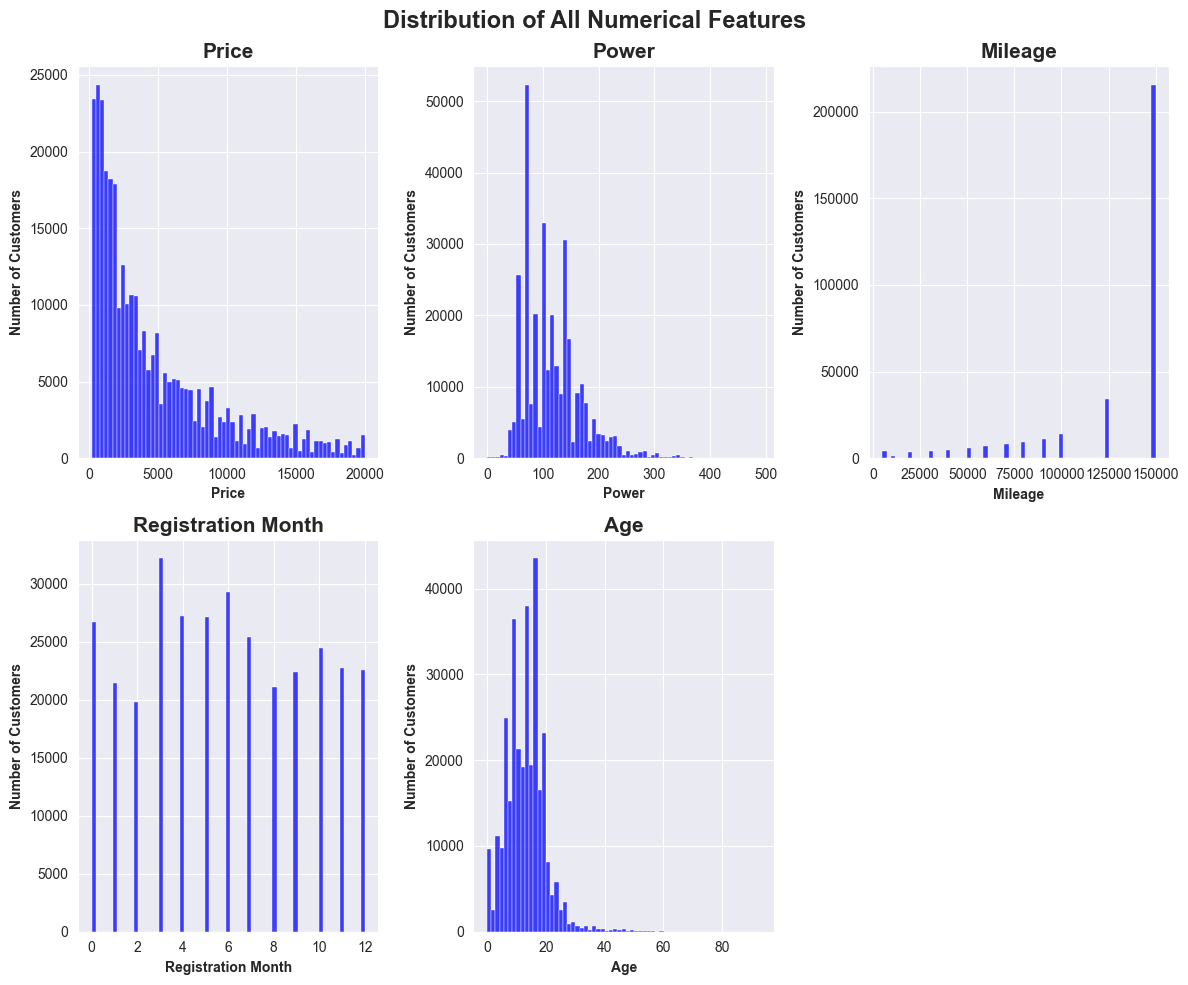

In [116]:
graph_numerical_features(data)

**Notes:**

Since we are working with used car data we will expect skewness in obvious directions: lower prices, lower horse-power, higher mileage, and higher ages. These assumptions are confirmed by the graphs above except for perhaps `age`. The age column does have some outliers that we intentionally left in during pre-processing to try maintain as much integrity to the original dataset as possible. If we were to remove these outliers however (the extremely high ages) I think we would actually see a more normal distribution versus the skwewed one we currently observe. Also, registration month, as reviewed earlier, is mostly uniform in shape. 

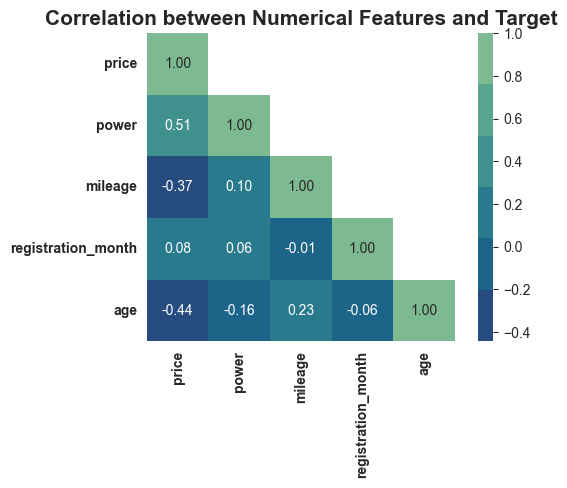

In [117]:
# Show correlation of numerical variables to the target
sns.set_style('white')
plt.figure(figsize = (6,4))

# Identify the numerical columns
nume_cols = [col for col in data.columns if data[col].dtypes == 'int64']

# obtain correlations
corrs = data[nume_cols].corr()

# take away redundant information
mask = np.triu(np.ones(corrs.shape, dtype = bool), 
               k = 1)

# plot heatmap
sns.heatmap(corrs, annot = True, fmt = '.2f',
            cmap = sns.color_palette('crest_r'),
            square = True, cbar = True, mask = mask)

plt.title("Correlation between Numerical Features and Target",
          fontsize = 15, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')

plt.show()

Based on the plot above, `price` has the strongest positive correlation to `power` and a moderate negative correlation to both `mileage` and `age`. `registration_month` appears to have little to no correlation to any other feature - not sure why the registration month would be used in price prediction personally. Removing this feature would reduce learning time, prediction time, and overall noise. Perhaps we can compare `rmse` during model training, I'm predicting no difference between them. The only difference will be the amount of time it took to achieve the prediction. 

In [118]:
#make copy and drop low correlation feature
data_w_month = data.copy()

data = data.drop(columns = 'registration_month')

=================================================================================================================

## 4.2 Categorical Features ##
<a id='cats'></a>

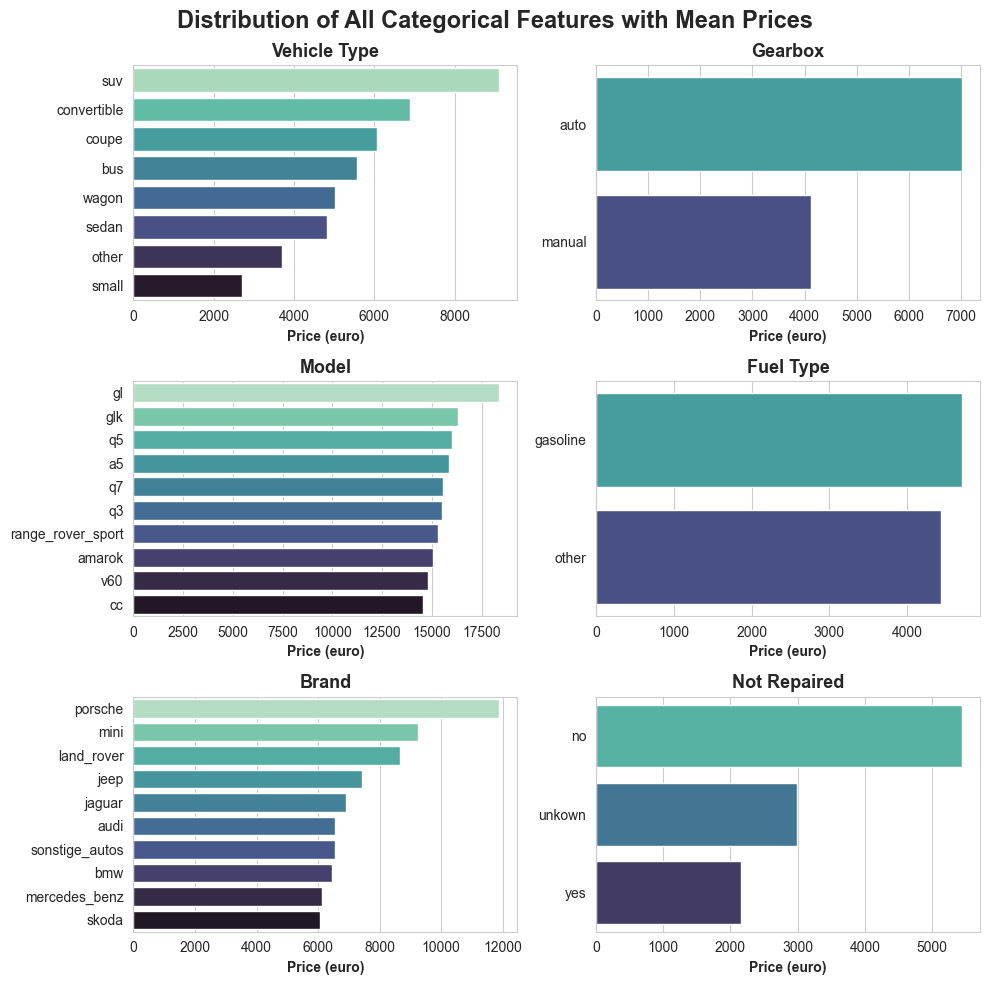

In [119]:
graph_categorical_features(data)

From the bar charts, the mean prices vary across the categories, except for maybe `model`, but this shows us that these features are good predictors for the target (`price`). Let's take a look at the minimum of the models to ensure that the spread is large enough, as there are 251 different models in the data set. 

In [120]:
data.groupby('model')['price'].mean().min()

642.9154929577464

With the min being so low of 251 models compared to only the top 10, we can comfortably say that model is also a good price indicator, and likely the most accurate. Which makes sense!

[Back to Contents](#contents)

# 5. Model Training #
<a id='training'></a>
_________________________________________________________________________________________________________________________________________________________

The functions below will help automate the tasks in this section. 

In [121]:
def rmse_fix(rmse_array):

    return np.abs(round(rmse_array.mean(), 2))

As mention in the [introduction](#intro), to predict `price` the foqllowing models wille be trained:
- sanity model: DummyRegressor that predicts the mean
- Baseline model for Gradient Boosting techniques: LinearRegressor
- Non-Gradient techniques: Random Forest and Decision Tree
- Gradient techniques: LightGBM, XGBoost, and CatBoost

For the categorical features, one-hot encoding will be performed. It's important to note that CatBoost and LightGBM can handle categorical features internally, so we will compare the difference between OHE and internal handling for these models. 

For the numerical features, feature scaling via a standardized scaler will be performed so that the models converge faster, especially with gradient descent.

Lastly, the root mean squared error (`RMSE`) will be used to compare the performance of the models. In addition, the training time and prediction time will be measured. 

In [122]:
# update nume_cols
nume_cols = [col for col in data.columns if data[col].dtypes == 'int64' and col != 'price']
nume_cols

['power', 'mileage', 'age']

In [123]:
# One-hot encoding of cat features
data_ohe = pd.get_dummies(data, drop_first = True)

In [124]:
# Define features and target
X = data.drop(columns = ['price'])
X_enc = data_ohe.drop(columns = ['price'])
y = data['price']

In [125]:
# Split the data 70:30 (training:test)
X_train, X_test, X_enc_train, X_enc_test, y_train, y_test = train_test_split(
    X, X_enc, y, test_size = 0.3, random_state = 12345
)

# Confirm shapes
split_sets = {
    'X_train': X_train,
    'X_test': X_test,
    'X_enc_train': X_enc_train,
    'X_enc_test': X_enc_test,
    'y_train': y_train,
    'y_test': y_test
}

for name, split in split_sets.items():
    print(f"Shape of {name}: ", split.shape)

Shape of X_train:  (225787, 9)
Shape of X_test:  (96766, 9)
Shape of X_enc_train:  (225787, 303)
Shape of X_enc_test:  (96766, 303)
Shape of y_train:  (225787,)
Shape of y_test:  (96766,)


In [126]:
# Apply feature scaling
sc = StandardScaler()

split_sets['X_train'][nume_cols] = sc.fit_transform(split_sets['X_train'][nume_cols])

keys_to_scale = ['X_test', 'X_enc_train', 'X_enc_test']

for key in keys_to_scale:
    split_sets[key][nume_cols] = sc.transform(split_sets[key][nume_cols])

In [127]:
# Check the sets
print('\033[1m' + 'X_train' + '\033[0m')
display(split_sets['X_train'][nume_cols].head(3))
print()

for key in keys_to_scale:
    print('\033[1m' + key + '\033[0m')
    display(split_sets[key][nume_cols].head(3))
    print()

X_train


,power,mileage,age
115214,-1.220364,0.582849,0.543781
192625,-0.819055,0.582849,-1.962544
124342,-0.819055,0.582849,-0.193373



X_test


,power,mileage,age
73133,-0.819055,-0.089876,-0.193373
210804,0.862618,0.582849,-0.193373
30679,-0.169318,-1.031691,-0.488235



X_enc_train


,power,mileage,age
115214,-1.220364,0.582849,0.543781
192625,-0.819055,0.582849,-1.962544
124342,-0.819055,0.582849,-0.193373



X_enc_test


,power,mileage,age
73133,-0.819055,-0.089876,-0.193373
210804,0.862618,0.582849,-0.193373
30679,-0.169318,-1.031691,-0.488235


In [128]:
# Establish metric for custom scorer
rmse_score = make_scorer(root_mean_squared_error, greater_is_better = False)

_For previous projects, I have used a custom best model search function, which could be used again here. However, since this project doesn't require that much flexibility and will need more optimization since the projects focus is on gradient boosting methods, I will revert to using GridSearchCV for this project._

==================================================================================================================

## 5.1 Sanity Model ##
<a id='sanity'></a>

No reason to perform a grid search for the sanity model, or for the linear regression baseline model as there are no hyperparameters to tune. 

In [129]:
# Create dictionary to store all model
results = {}

models_to_score = ['Sanity', 'Linear Regression', 'Random Forest', 
                   'CatBoost', 'LightGBM', 'XGBoost',
                   'CatBoost OHE', 'LightGBM OHE']

for model in models_to_score:
    results[model] = {}

In [130]:
results

{'Sanity': {},
 'Linear Regression': {},
 'Random Forest': {},
 'CatBoost': {},
 'LightGBM': {},
 'XGBoost': {},
 'CatBoost OHE': {},
 'LightGBM OHE': {}}

In [131]:
%%time
# train the sanity model
sanity = DummyRegressor(strategy = 'mean')

sanity_rmse = cross_val_score(estimator = sanity, 
                              X = X_enc_train,
                              y = y_train,
                              scoring = rmse_score,
                              cv = 3,
                              n_jobs = -1)

sanity_rmse = rmse_fix(sanity_rmse)

CPU times: total: 125 ms
Wall time: 1.7 s


In [132]:
# store the results
results['Sanity']['best_model'] = sanity
results['Sanity']['best_params'] = None
results['Sanity']['rmse'] = sanity_rmse

# Show the model
print(f"The best RMSE for the Sanity model is:", results['Sanity']['rmse'])

The best RMSE for the Sanity model is: 4541.58


[Back to Contents](#contents)

## 5.2 Linear Regression ##
<a id='baseline'></a>

In [133]:
%%time
# train the lr model
lr = LinearRegression()

lr_rmse = cross_val_score(estimator = lr, 
                              X = X_enc_train,
                              y = y_train,
                              scoring = rmse_score,
                              cv = 3,
                              n_jobs = -1)

lr_rmse = rmse_fix(lr_rmse)

CPU times: total: 15.6 ms
Wall time: 4.44 s


In [134]:
# Store the result
results['Linear Regression']['best_model'] = lr
results['Linear Regression']['best_params'] = None
results['Linear Regression']['rmse'] = lr_rmse

# Show the model
print(f"The best RMSE for the Linear Regression model is:", results['Linear Regression']['rmse'])

The best RMSE for the Linear Regression model is: 2721.85


This performed better than our sanity DummyRegressor as we hoped, therefore this can comfortably be our baseline for the future trained models. 

[Back to Contents](#contents)

## 5.3 Random Forest
<a id='forest'></a>

In [135]:
%%time
# Build the random forest with n_estimators = 30
rf_test = RandomForestRegressor(n_estimators=30, random_state=12345, n_jobs=-1)
rf_test.fit(X_enc_train, y_train)

CPU times: total: 9min 35s
Wall time: 21.9 s


RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=12345)

In [136]:
# Find the min and max depths of 30 trees
min_depth = 1e6
max_depth = 0

for i, tree in enumerate(rf_test.estimators_):
    depth = tree.get_depth()
    if depth < min_depth:
        min_depth = depth
    if depth > max_depth:
        max_depth = depth

print('The minimum depth of 30 trees:', min_depth)
print('The maximum depth of 30 trees:', max_depth)

The minimum depth of 30 trees: 70
The maximum depth of 30 trees: 96


The minimum and maximum depths of 30 trees are 70 and 96. To prevent overfitting, we will set a lower value for max_depth.

In [137]:
%%time
rf = RandomForestRegressor()
rf_grid = {
    'max_depth': range(50, 71, 10),
    'n_estimators': range(20, 51, 10),
    'n_jobs': [14],
    'random_state': [12345]
}

rf_search = GridSearchCV(
    estimator = rf,
    param_grid = rf_grid,
    scoring = rmse_score,
    n_jobs = 14,
    cv = 3
)
rf_search.fit(X_enc_train, y_train)

CPU times: total: 6min 16s
Wall time: 11min 12s


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=14,
             param_grid={'max_depth': range(50, 71, 10),
                         'n_estimators': range(20, 51, 10), 'n_jobs': [14],
                         'random_state': [12345]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [138]:
# store the results
results['Random Forest']['best_model'] = rf_search.best_estimator_
results['Random Forest']['best_params'] = rf_search.best_params_
results['Random Forest']['rmse'] = rmse_fix(rf_search.best_score_)

# show best model
print("The best RMSE for the Random Forest model is:", results['Random Forest']['rmse'])

The best RMSE for the Random Forest model is: 1660.97


In [139]:
results['Random Forest']

{'best_model': RandomForestRegressor(max_depth=70, n_estimators=50, n_jobs=14,
                       random_state=12345),
 'best_params': {'max_depth': 70,
  'n_estimators': 50,
  'n_jobs': 14,
  'random_state': 12345},
 'rmse': 1660.97}

[Back to Contents](#contents)

## 5.4 LightGBM ##
<a id='lgbm'></a>

The following hyperparameters will be tuned for the LightGBM model:

- `num_leaves`: Maximum number of leaves per tree.
    - Larger values tend to increase model complexity but also risk overfitting.
- `learning_rate`: Controls how quickly the model adjusts weights with respect to the error.
    - Lower values tend to make the model learn more slowly, but can yield better performance with more boosting iterations. 
- `n_estimators`: The number of boosting iterations or trees.
    - Lower learning_rate usually requires higher n_estimators.
- `max_depth`: Maximum depth of each tree. Deeper trees capture more information but may lead to overfitting.
    - lower values can prevent overtting, but too low will underfit.
- `feature_fraction`: The proportion of features to be randomly selected for each tree.
    - Helps in regularizing the model and making it more robust.
- `min_data_in_leaf`: Minimum number of samples required in a leaf node to prevent overfitting.
    - Higher values can help regularize the model and prevent small leaves from overfitting.
- `lambda_l2`: Regularization parameter for controlling the L2 penalty, which is used to shrink the coefficients in the model.
    - Increasing adds penalty to large coefficients, which can help reduce overfitting. Discourages model from assigning too much weight to a feature.
 
We will also revert from using the GridSearchCV function as it would take too long. In order to optimize the hyperparamters and reduce the search time we will operate with the RandomizedSearchCV function. Instead of searching through _every_ combination of hyperparameters, it randomly selects a fixed number of parameter combinations to try. This will significantly reduce run time while exploring the parameter space more broadly.

### 5.4.1 LightGBM (OHE) ###

In [140]:
%%time
# Establish lgbm regressor
lgbm = LGBMRegressor()

# Define parameter grid
lgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': range(100, 1001, 100),
    'max_depth': range(5, 16),
    'num_leaves': range(20, 51, 5),
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': np.linspace(0.5, 1.0, 6),
    'lambda_l2': np.logspace(-2, 2, 6),
    'random_state': [12345],
    'verbose': [-1]
}

# set up RCV
lgbm_rsearch = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbm_grid,
    n_iter = 100,
    scoring = rmse_score,
    cv = 3,
    n_jobs = 14,
    random_state = 12345
)

lgbm_rsearch.fit(X_enc_train, y_train)

CPU times: total: 33.7 s
Wall time: 5min 10s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=100, n_jobs=14,
                   param_distributions={'feature_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'lambda_l2': array([1.00000000e-02, 6.30957344e-02, 3.98107171e-01, 2.51188643e+00,
       1.58489319e+01, 1.00000000e+02]),
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': range(5, 16),
                                        'min_data_in_leaf': [10, 20, 30],
                                        'n_estimators': range(100, 1001, 100),
                                        'num_leaves': range(20, 51, 5),
                                        'random_state': [12345],
                                        'verbose': [-1]},
                   random_state=12345,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [141]:
# Store the results
results['LightGBM OHE']['best_model'] = lgbm_rsearch.best_estimator_
results['LightGBM OHE']['best_params'] = lgbm_rsearch.best_params_
results['LightGBM OHE']['rmse'] = rmse_fix(lgbm_rsearch.best_score_)

# show best model
print("The best RMSE for the LightGBM model with OHE is:", results['LightGBM OHE']['rmse'])

The best RMSE for the LightGBM model with OHE is: 1594.43


In [142]:
lgbm_rsearch.best_params_

{'verbose': -1,
 'random_state': 12345,
 'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 10,
 'max_depth': 11,
 'learning_rate': 0.1,
 'lambda_l2': 2.5118864315095824,
 'feature_fraction': 1.0}

### 5.4.2 LightGBM (Internal Categorical Handling) ###

In [143]:
# Prepare the categorical features for lgbm
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

X_train_lgbm[cat_cols] = X_train_lgbm[cat_cols].astype('category')
X_test_lgbm[cat_cols] = X_test_lgbm[cat_cols].astype('category')

In [144]:
%%time
# Establish lgbm regressor
lgbm = LGBMRegressor()

# Define parameter grid
lgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': range(100, 1001, 100),
    'max_depth': range(5, 16),
    'num_leaves': range(20, 51, 5),
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': np.linspace(0.5, 1.0, 6),
    'lambda_l2': np.logspace(-2, 2, 6),
    'random_state': [12345],
    'verbose': [-1]
}

# set up RCV
lgbm_rsearch = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbm_grid,
    n_iter = 100,
    scoring = rmse_score,
    cv = 3,
    n_jobs = 14,
    random_state = 12345
)

lgbm_rsearch.fit(X_train_lgbm, y_train)

CPU times: total: 37.2 s
Wall time: 5min 15s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=100, n_jobs=14,
                   param_distributions={'feature_fraction': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'lambda_l2': array([1.00000000e-02, 6.30957344e-02, 3.98107171e-01, 2.51188643e+00,
       1.58489319e+01, 1.00000000e+02]),
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': range(5, 16),
                                        'min_data_in_leaf': [10, 20, 30],
                                        'n_estimators': range(100, 1001, 100),
                                        'num_leaves': range(20, 51, 5),
                                        'random_state': [12345],
                                        'verbose': [-1]},
                   random_state=12345,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [145]:
# Store the results
results['LightGBM']['best_model'] = lgbm_rsearch.best_estimator_
results['LightGBM']['best_params'] = lgbm_rsearch.best_params_
results['LightGBM']['rmse'] = rmse_fix(lgbm_rsearch.best_score_)

# show best model
print("The best RMSE for the LightGBM model is:", results['LightGBM']['rmse'])

The best RMSE for the LightGBM model is: 1576.1


In [146]:
lgbm_rsearch.best_params_

{'verbose': -1,
 'random_state': 12345,
 'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 10,
 'max_depth': 11,
 'learning_rate': 0.1,
 'lambda_l2': 2.5118864315095824,
 'feature_fraction': 1.0}

## 5.5 CatBoost ##
<a id='catboost'></a>

The following hyperparameters will be tuned for the CatBoost models:

- `iterations`: The number of trees in the model.
    - More iterations typically lead to better performance at the cost of overfitting
- `depth`:  The depth of each tree in the ensemble.
    - Deeper trees can capture more complex patterns at the cost of overfitting
- `learning_rate`: The step size at each boosting iteration
    - Smaller values make the model learn more slowly, but improve generalization. Larger values can cause overfitting.
- `l2_leaf_reg`: L2 regularization term applied to leaf values to prevent overfitting.
    - Helps control model complexity and reduce overfitting by penalizing large values of leaf weights.
- `colsample_bylevel`: Fraction of features to be randomly selected at each tree level.
    - Can reduce overfitting by using a subset of features at each split.
- `subsample`: The fraction of training samples used to grow each tree.
    - Lower values reduce overfitting by introducing more randomness
 
We will continue to use the RandomSearchCV function. 

### 5.5.1 CatBoost (OHE) ###

In [147]:
%%time
# Establish lgbm regressor
kitty = CatBoostRegressor()

# Define parameter grid
kitty_grid = {
    'iterations': range(10, 301),
    'depth': range(4, 13),
    'learning_rate': np.logspace(-2, 0, num = 50),
    'l2_leaf_reg': range(3, 20),
    'colsample_bylevel': np.linspace(0.4, 0.8, num = 10),
    'subsample': np.linspace(0.4, 0.7, num = 10),
    'verbose': [0],
    'early_stopping_rounds': [50]
}

# set up RCV
kitty_rsearch = RandomizedSearchCV(
    estimator = kitty,
    param_distributions = kitty_grid,
    n_iter = 100,
    scoring = rmse_score,
    cv = 3,
    n_jobs = 14,
    random_state = 12345
)

kitty_rsearch.fit(X_enc_train, y_train)

CPU times: total: 1min 3s
Wall time: 6min 23s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000016F65BD3790>,
                   n_iter=100, n_jobs=14,
                   param_distributions={'colsample_bylevel': array([0.4       , 0.44444444, 0.48888889, 0.53333333, 0.57777778,
       0.62222222, 0.66666667, 0.71111111, 0.75555556, 0.8       ]),
                                        'depth': range(4, 13),
                                        'early_stopping_rounds': [50],
                                        'iterations': range(10, 301),
                                        'l2_leaf_reg'...
       0.26826958, 0.29470517, 0.32374575, 0.35564803, 0.39069399,
       0.42919343, 0.47148664, 0.51794747, 0.5689866 , 0.62505519,
       0.68664885, 0.75431201, 0.82864277, 0.91029818, 1.        ]),
                                        'subsample': array([0.4       , 0.43333333, 0.46666667, 0.5       , 0.53333333,
       0.56666667, 0.6       , 0.63333333, 0.66666667, 0.7       ]),
                                        'verbose': [0]},
                   random_state=12345,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [148]:
# Store the results
results['CatBoost OHE']['best_model'] = kitty_rsearch.best_estimator_
results['CatBoost OHE']['best_params'] = kitty_rsearch.best_params_
results['CatBoost OHE']['rmse'] = rmse_fix(kitty_rsearch.best_score_)

# show best model
print("The best RMSE for the CatBoost model with OHE is:", results['CatBoost OHE']['rmse'])

The best RMSE for the CatBoost model with OHE is: 1607.52


In [149]:
kitty_rsearch.best_params_

{'verbose': 0,
 'subsample': 0.43333333333333335,
 'learning_rate': 0.35564803062231287,
 'l2_leaf_reg': 4,
 'iterations': 252,
 'early_stopping_rounds': 50,
 'depth': 12,
 'colsample_bylevel': 0.6666666666666667}

### 5.5.2 CatBoost (Internal Categorical Handling) ###

In [150]:
%%time
# Establish lgbm regressor
cat = CatBoostRegressor()

# Define parameter grid
cat_grid = {
    'iterations': range(10, 301),
    'depth': range(4, 13),
    'learning_rate': np.logspace(-2, 0, num = 50),
    'l2_leaf_reg': range(3, 20),
    'colsample_bylevel': np.linspace(0.4, 0.8, num = 10),
    'subsample': np.linspace(0.4, 0.7, num = 10),
    'verbose': [0],
    'early_stopping_rounds': [50],
    'cat_features': [cat_cols]
}

# set up RCV
cat_rsearch = RandomizedSearchCV(
    estimator = cat,
    param_distributions = cat_grid,
    n_iter = 100,
    scoring = rmse_score,
    cv = 3,
    n_jobs = 12,
    random_state = 12345,
)

cat_rsearch.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: total: 1min 4s
Wall time: 16min 7s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000016F65BD8D10>,
                   n_iter=100, n_jobs=12,
                   param_distributions={'cat_features': [['vehicle_type',
                                                          'gearbox', 'model',
                                                          'fuel_type', 'brand',
                                                          'not_repaired']],
                                        'colsample_bylevel': array([0.4       , 0.44444444, 0.48888889, 0.53333333, 0.57777778,
       0.62222222, 0.66666667, 0.71111111, 0.75555556, 0.8       ]),
                                        'd...
       0.26826958, 0.29470517, 0.32374575, 0.35564803, 0.39069399,
       0.42919343, 0.47148664, 0.51794747, 0.5689866 , 0.62505519,
       0.68664885, 0.75431201, 0.82864277, 0.91029818, 1.        ]),
                                        'subsample': array([0.4       , 0.43333333, 0.46666667, 0.5       , 0.53333333,
       0.56666667, 0.6       , 0.63333333, 0.66666667, 0.7       ]),
                                        'verbose': [0]},
                   random_state=12345,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [151]:
# Store the results
results['CatBoost']['best_model'] = cat_rsearch.best_estimator_
results['CatBoost']['best_params'] = cat_rsearch.best_params_
results['CatBoost']['rmse'] = rmse_fix(cat_rsearch.best_score_)

# show best model
print("The best RMSE for the CatBoost model is:", results['CatBoost']['rmse'])

The best RMSE for the CatBoost model is: 1614.4


In [152]:
cat_rsearch.best_params_

{'verbose': 0,
 'subsample': 0.4666666666666667,
 'learning_rate': 0.29470517025518095,
 'l2_leaf_reg': 6,
 'iterations': 267,
 'early_stopping_rounds': 50,
 'depth': 11,
 'colsample_bylevel': 0.7111111111111111,
 'cat_features': ['vehicle_type',
  'gearbox',
  'model',
  'fuel_type',
  'brand',
  'not_repaired']}

[Back to Contents](#contents)

## 5.6 XGBoost ##
<a id='xgboost'></a>

One new hyperparameter that is exclusive to the XGBoost model will be tuned: `gamma`.

`Gamma` is a parameter that controls how conservative the model is when making splits. It specifies the minimum reduction in the loss function required to make a split at a node. Essentially, it sets the minimum improvement needed in the model's performance to allow a split at a decision tree node. This can help prevent overfitting, so we will explore it. 

In [153]:
%%time
xgb = XGBRegressor()

xgb_grid = {
    'n_estimators': range(100, 501, 100),
    'max_depth': range(5, 16),
    'learning_rate': np.logspace(-2, 0, 20),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': range(0,6),
    'reg_lambda': np.logspace(-2, 2, 6),
    'random_state': [12345]
}

# set up RCV
xgb_rsearch = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = xgb_grid,
    n_iter = 100,
    scoring = rmse_score,
    cv = 3,
    n_jobs = 14,
    random_state = 12345,
)

xgb_rsearch.fit(X_enc_train, y_train)

CPU times: total: 3min 43s
Wall time: 15min 48s


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ]),
                                        'max_depth': range(5, 16),
                                        'n_estimators': range(100, 501, 100),
                                        'random_state': [12345],
                                        'reg_lambda': array([1.00000000e-02, 6.30957344e-02, 3.98107171e-01, 2.51188643e+00,
       1.58489319e+01, 1.00000000e+02]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=12345,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [154]:
# Store the results
results['XGBoost']['best_model'] = xgb_rsearch.best_estimator_
results['XGBoost']['best_params'] = xgb_rsearch.best_params_
results['XGBoost']['rmse'] = rmse_fix(xgb_rsearch.best_score_)

# show best model
print("The best RMSE for the XGBoost model is:", results['XGBoost']['rmse'])

The best RMSE for the XGBoost model is: 1572.29


In [155]:
xgb_rsearch.best_params_

{'subsample': 0.6,
 'reg_lambda': 2.5118864315095824,
 'random_state': 12345,
 'n_estimators': 500,
 'max_depth': 13,
 'learning_rate': 0.0545559478116852,
 'gamma': 5,
 'colsample_bytree': 0.7}

[Back to Contents](#contents)

# 6. Model Evaluations and Analysis #
<a id='evals'></a>
_________________________________________________________________________________________________________________________________________________________

The functions below will help automate tasks in this section. 

In [156]:
def time_eval(model, X_train, y_train, X_test, y_test):
    '''
    This function will take a model, and train it while tracking the time to train.
    Then, the model will be tested and scored via RMSE while tracking prediciton time. 
    The function returns the training time, prediction time, RMSE, and the model.
    The function converts the time to milliseconds for visualization ease. 
    '''

    # Train the model and record the time
    train_start = time.perf_counter()
    model.fit(X_train, y_train)
    
    train_time = round((time.perf_counter() - train_start) * 1000)

    # Predict on the test set and record the time
    pred_start = time.perf_counter()
    preds = model.predict(X_test)

    pred_time = round((time.perf_counter() - pred_start) * 1000)

    # Calculate rmse
    rmse = rmse_fix(root_mean_squared_error(y_test, preds))

    return train_time, pred_time, rmse, model

==================================================================================================================

We have performed hyperparameter tuning on 6 of our 8 models (_2 are baseline models_). Now that we have our model parameters, we can now retrain them and validate them on the test set while simultaneously collecting time information on training and predictions. We will store all of the information in a dataframe for review and analysis afterwards. Let's use a loop to loop through the models to gather the data for the dataframe. 

It's also important to note that some of our models used different training sets. Let's summarize which models used which sets below to organize our loop. 

- `X_train`: Cat
- `X_enc_train`: Dummy, LR, RF, LGBM-OHE, Cat-OHE, XGB
- `X_train_lgbm`: LGBM-Internal

In [157]:
# Create final dataframe
final_results = pd.DataFrame(columns = [
    'model_name', 'train_rmse', 'test_rmse', 
    'train_time (ms)', 'pred_time (ms)' 
])

In [158]:
%%time
for model_name in models_to_score:
    # Define which test and train set to use
    if model_name == 'CatBoost':
        X_tr = X_train
        X_ts = X_test
    elif model_name == 'LightGBM':
        X_tr = X_train_lgbm
        X_ts = X_test_lgbm
        
    else:
        X_tr = X_enc_train
        X_ts = X_enc_test

    t_time, p_time, rmse, model = time_eval(
        model = results[model_name]['best_model'],
        X_train = X_tr,
        y_train = y_train,
        X_test = X_ts,
        y_test = y_test
    )

    # Save the results
    results[model_name]['best_model'] = model

    new_row = pd.DataFrame({
        'model_name': [model_name],
        'train_rmse': [results[model_name]['rmse']],
        'test_rmse': [rmse],
        'train_time (ms)': [t_time],
        'pred_time (ms)': [p_time]
    })

    # Add row to final_df
    final_results = pd.concat([final_results, new_row])

<timed exec>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


CPU times: total: 11min 27s
Wall time: 1min 59s


In [159]:
# observe
final_results.sort_values(by = 'test_rmse')

,model_name,train_rmse,test_rmse,train_time (ms),pred_time (ms)
0,XGBoost,1572.29,1553.34,8393,265
0,LightGBM,1576.10,1562.88,1972,306
0,LightGBM OHE,1594.43,1577.54,2178,417
0,CatBoost OHE,1607.52,1591.75,38750,37
0,CatBoost,1614.40,1601.85,35496,133
0,Random Forest,1660.97,1634.25,29479,269
0,Linear Regression,2721.85,2711.97,1806,128
0,Sanity,4541.58,4549.54,1,0


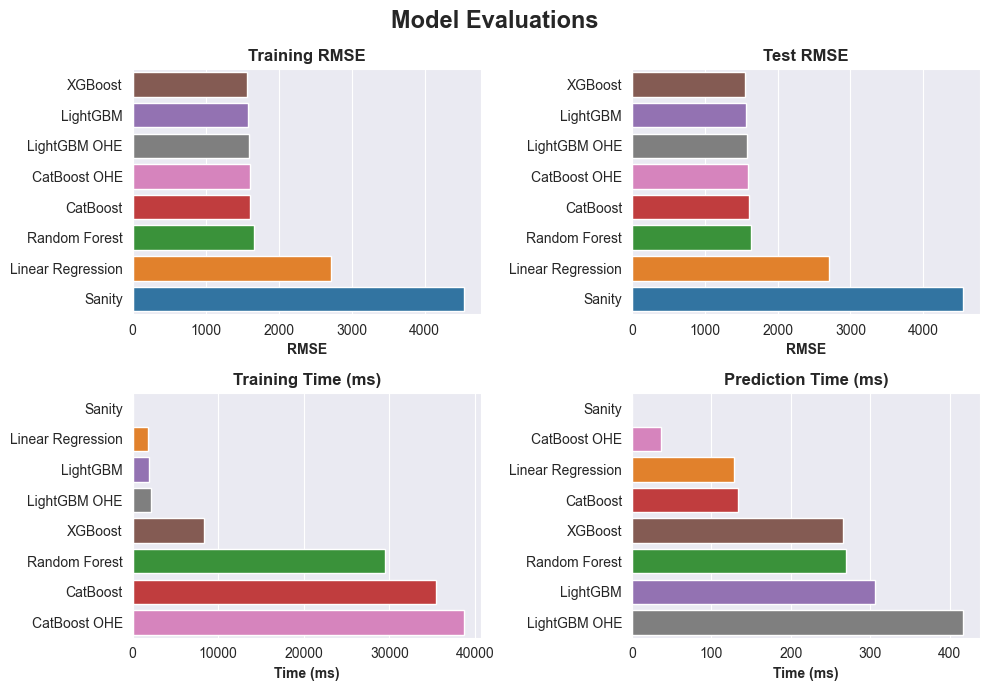

In [166]:
# Visualize the dataframe
sns.set_style('darkgrid')

palette = sns.color_palette("tab10", n_colors = 8)
model_to_color = dict(zip(final_results['model_name'].unique(), palette))

# List of characteristics to plot
metrics = ['train_rmse', 'test_rmse', 'train_time (ms)', 'pred_time (ms)']
titles = ['Training RMSE', 'Test RMSE', 'Training Time (ms)', 'Prediction Time (ms)']
xlabels = ['RMSE', 'RMSE', 'Time (ms)', 'Time (ms)']

# Create the figure
fig, axs = plt.subplots(2,2, figsize = (10, 7))
plt.suptitle("Model Evaluations", fontsize = 17, fontweight = 'bold')
axs = axs.flatten()

# Loop through metrics and create barchart
for i, metric in enumerate(metrics):
    sorted_data = final_results.sort_values(by = metric)
    
    sns.barplot(x = metric, y = 'model_name', 
                data = sorted_data, ax = axs[i],
                hue = 'model_name',
                palette = [model_to_color[m] for m in sorted_data['model_name']])
    
    axs[i].set_title(titles[i], fontweight = 'bold')
    axs[i].set_xlabel(xlabels[i], fontsize = 10, fontweight = 'bold')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Analysis**
- `XGBoost` achieved the best performance with the lowest RMSE on the test dataset (**1553.34**), and of the fast training time models, it was the slowest. The other way to phrase that is of the slow training time models, it was the fastest, as it is right in the middle of the models in terms of training times. In terms of prediction times, it is one of the slower models. Realistically, it is prediciting in less than 300 ms, which is significantly less than a second.
- `LightGBM` is a competitive model as it was the second most accurate model and has the shortest training time, but has the second longest prediction time.
- `CatBoost` and `CatBoost OHE` perform similarly when observing their metrics. The RMSE values are similar, as most of the gradient method models do. It appears from this projects' data that the CatBoost OHE model performed better than the internal model, but trained at a similar time. There is a slight difference in prediction time as the OHE model is significantly faster than the internal model. In fact, if Rusty Bargain wanted prediction speed and accuracy both as their choice criteria, than `CatBoost OHE` is a decent model choice.
- `Non-Gradient Boosting Methods` did not perform as well by comparison as expected. We observe larger RMSE values, large training times (except for Linear Regression) and moderate prediction times.

With these metrics on display, and based on the criteria given to us by Rusty Bargain, The prediction time is so small that each model is a decent choice, therefore, in combination of high performance and low training time, the `LightGBM` is the final model that I would provide for Rusty Bargain. 

[Back to Contents](#contents)

# 7. Conclusion #
<a id='conclusion'></a>


### Data Exploration ###

Rusty Bargain provided us with a dataset of 354369 rows and 16 columns of information related to used vehicles; with the intention of developing an application to predict the price based on characteristics of the vehicle. After exploring the data, we observed the following:
- Columns were in pascal case instead of snake case.
- The date columns were not of the datatype datetime.
- Discovered 13 months in `registration_month` -- investigation needed.
- 30% of the data's rows contained missing values.
    - Specifically, only categorical features had missing values: `vehicle_type`, `gearbox`, `model`, `brand`, and `not_repaired`.
- 262 duplicate rows were found and dropped
- Possible anomalous values found in `price`, `registration_year`, `registration_month`, and `power`.
- Potentially useless columns observed in `postal_code` and `number_of_pictures` -- ultimately dropped.

### Data Preprocessing ###

In this stage, the following actions were taken to address issues found in exploration:

- **Fuel Types**:
  - Combined petrol and gasoline as they represent the same fuel.
  - Due to the small proportion of non-gasoline types, they were grouped into an "Other" category.

- **Anomalous Values**:
  - **Price**: Removed values below €200 as they were deemed unrealistic.
  - **Year**: Removed entries before 1923 and after 2016 (since the dataset's creation date was in 2016).
  - **Power**: Removed values above 500 (illogical), but kept cars with a power value of 0, as this group showed patterns.

- **Registration Month**: 
  - The month '0' data showed patterns in price, power, and mileage, so it was left unchanged to avoid overfitting.

- **Missing Value Handling**:
  - **Vehicle Type**: Imputed using modal values based on brand and year.
  - **Model**: Filled missing values with "unknown" since the data was not random.
  - **Fuel Type**: Imputed by vehicle type and model; remaining unknowns were combined into "Other."
  - **Not Repaired**: Filled with "unknown" since this feature couldn't be inferred from other data.
  - **Gearbox**: Imputed based on patterns observed within models.

- **Dimensionality Reduction**:
  - Imputed 0-power vehicles based on year, showing differences in ECDF plots.
  - Removed unnecessary columns (`postal_code`, `date_crawled`, `last_seen`).
  - Created an `age` column using `year` and `date_created`, then removed the original date columns.


### Exploratory Data Analysis ###

- **Numerical Features**
    - Observed some expected skewness in the histograms.
    - The correlation matrix showed that `power` had the strongest positive relation to `price` while `mileage` and `age` had a moderate negative relation.
    - `registration_month` showed no correlation to any other feature in the matrix and therefore was dropped from the dataset.
- **Categorical Features**
    - Barchart analysis showed that the prices varied across each feature indicating that all were strong predictors of `price`. 

### Model Training ###
- A total of eight models were trained and 6 were tuned for the hyperparameters. The baseline models were a DummyRegressor and Linear Regression. Whereas the 6 tuned models were Random Forest, LightGBM, LightGBM (OHE), CatBoost, CatBoost (OHE), and XGBoost. The evaluation metric used across the models was the Root Mean Squared Error (RMSE).
- One-hot encoding was performed for the categorical features for the models that needed it. LightGBM and CatBoost were tested both with OHE and with their internal handling.
- For the numerical features, feature scaling was conducted using a standard scaler so that gradient boosting models converge better and faster.

### Model Analysis ###

The baseline models had the lowest RMSE score of 4549.54 (_Dummy Regressor_) and 2711.97 (_Linear Regression_) while the rest of the models have similar scores. However, the gradient boosting techniques shown superior over the non-gradient technique of the Random Forest model with their lower training and prediction times. 

Overall, the **`LightGBM model`** with internal handling of categorical features should fulfill Rusty Bargain's requirements of high accuracy and low training and prediction times. Additionally there are no signs of overfitting with this model. 